In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import log
import ultranest
from ultranest.plot import cornerplot
from scipy.stats import poisson
from scipy.stats import norm
import pandas as pd
import healpy as hp
from healpy.newvisufunc import projview, newprojplot
import astropy.units as u
from numpy import pi, sin
from scipy.interpolate import interp1d
import scipy.stats as stats
import json
from matplotlib import colors as mcolors
from ultranest.utils import resample_equal
import ultranest.stepsampler
import os
import matplotlib.image as mpimg
import json
import corner
import os
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import LogNorm


In [2]:
pathname = '../log_dir/Dipole_and_Quadrupole_Data/'
folders = ['monopole_model/', 'dipole_model/', 'quadrupole_model/', 'dipole_quadrupole_model/']

dataframe = pd.DataFrame(columns=['model','Nbar', 'D', 'Q', 'evidence'])

for folder in folders:
    folder_path = os.path.join(pathname, folder)
    
    # Only walk the immediate subdirectories of folder_path
    for root, subdirs, _ in os.walk(folder_path):
        for subfolder in subdirs:
            # remove subfolder that ends in times
            if subfolder.endswith('times'):
                continue

            file_path = os.path.join(root, subfolder, 'chains/run.txt') # this is the path to the UN run folder
            
            with open(file_path, 'r') as f:
                splits = subfolder.split('_')
                Q = splits[-1]
                D = splits[-3]
                Nbar = splits[-5]
                if len(splits) == 8:
                    model = 'dipole_quadrupole'
                else:
                    model = splits[0]
                df = pd.read_csv(file_path, delim_whitespace=True, comment='#')
                evidence = df['logz'].iloc[-1]
                # add the evidence to a datafram
                new_row = pd.DataFrame([{'model': model, 'Nbar': Nbar, 'D': D, 'Q': Q, 'evidence': evidence}])
                dataframe = pd.concat([dataframe, new_row], ignore_index=True)
                # print(f"Evidence for {subfolder}: {evidence}")
                # break
            


        break  # Prevent descending into deeper levels

            

    

In [3]:
dataframe = dataframe.sort_values(by=['model'])
dataframe

,model,Nbar,D,Q,evidence
1199,dipole,75,0.02,0.01,-176005.278823
802,dipole,10,0.005,0.1,-125888.888164
801,dipole,100,0.05,0.005,-182543.544514
800,dipole,75,0.01,0.01,-175479.643812
799,dipole,150,0.1,0.1,-196372.063736
...,...,...,...,...,...
1597,quadrupole,25,0.05,0.12,-149026.427145
1596,quadrupole,100,0.1,0.02,-191268.494010
1595,quadrupole,150,0.01,0.175,-192951.183204
1593,quadrupole,25,0.05,0.15,-149353.347299


In [4]:
monopole_model = dataframe[dataframe['model'] == 'monopole']
dipole_model = dataframe[dataframe['model'] == 'dipole']
quadrupole_model = dataframe[dataframe['model'] == 'quadrupole']
dipole_quadrupole_model = dataframe[dataframe['model'] == 'dipole_quadrupole']

monopole_model = monopole_model.sort_values(by=['Nbar', 'D', 'Q']).reset_index(drop=True)
dipole_model = dipole_model.sort_values(by=['Nbar', 'D', 'Q']).reset_index(drop=True)
quadrupole_model = quadrupole_model.sort_values(by=['Nbar', 'D', 'Q']).reset_index(drop=True)
dipole_quadrupole_model = dipole_quadrupole_model.sort_values(by=['Nbar', 'D', 'Q']).reset_index(drop=True)


In [5]:
bayes_factors = pd.DataFrame(columns=['Comparison', 'Nbar', 'D', 'Q', 'bayes_factor'])
bayes_factors

# i've ordered these so they'll be the same for all 4 models
Nbar = dipole_quadrupole_model['Nbar'].values
D = dipole_quadrupole_model['D'].values
Q = dipole_quadrupole_model['Q'].values

S_3 = dipole_quadrupole_model['evidence'].values
S_2 = quadrupole_model['evidence'].values
S_1 = dipole_model['evidence'].values
S_0 = monopole_model['evidence'].values

B_32 = S_3 - S_2
B_31 = S_3 - S_1
B_30 = S_3 - S_0

# Combine into list of rows
rows = []

for i in range(len(S_3)):
    rows.append({'Comparison': 'B_32', 'Nbar': Nbar[i], 'D': D[i], 'Q': Q[i], 'bayes_factor': B_32[i]})
    rows.append({'Comparison': 'B_31', 'Nbar': Nbar[i], 'D': D[i], 'Q': Q[i], 'bayes_factor': B_31[i]})
    rows.append({'Comparison': 'B_30', 'Nbar': Nbar[i], 'D': D[i], 'Q': Q[i], 'bayes_factor': B_30[i]})

# Append all at once
bayes_factors = pd.concat([bayes_factors, pd.DataFrame(rows)], ignore_index=True)


In [6]:
bayes_factors = bayes_factors.sort_values(by=['Comparison', 'Nbar', 'D', 'Q']).reset_index(drop=True)
for col in ['Nbar', 'D', 'Q', 'bayes_factor']:
    bayes_factors[col] = pd.to_numeric(bayes_factors[col], errors='coerce')
bayes_factors

,Comparison,Nbar,D,Q,bayes_factor
0,B_30,0.1,0.005,0.005,-0.415897
1,B_30,0.1,0.005,0.010,-1.687571
2,B_30,0.1,0.005,0.020,-0.726075
3,B_30,0.1,0.005,0.050,-0.465304
4,B_30,0.1,0.005,0.075,-2.014696
...,...,...,...,...,...
1795,B_32,75.0,0.100,0.100,6168.866713
1796,B_32,75.0,0.100,0.120,6000.110195
1797,B_32,75.0,0.100,0.150,5905.090907
1798,B_32,75.0,0.100,0.175,6057.672735


In [9]:
bayes_factors.to_csv('../log_dir/Dipole_and_Quadrupole_Data/bayes_factors.csv', index=False)

# read in the bayes factors instead of calculating them


In [2]:
bayes_factors = pd.read_csv('../log_dir/Dipole_and_Quadrupole_Data/bayes_factors.csv')

In [4]:
B_30_df = bayes_factors[bayes_factors['Comparison'] == 'B_30']
B_31_df = bayes_factors[bayes_factors['Comparison'] == 'B_31']
B_32_df = bayes_factors[bayes_factors['Comparison'] == 'B_32']

In [5]:
B_32_df

,Comparison,Nbar,D,Q,bayes_factor
1200,B_32,0.1,0.005,0.005,0.190271
1201,B_32,0.1,0.005,0.010,-1.232069
1202,B_32,0.1,0.005,0.020,-0.480848
1203,B_32,0.1,0.005,0.050,-0.581593
1204,B_32,0.1,0.005,0.075,-1.053238
...,...,...,...,...,...
1795,B_32,75.0,0.100,0.100,6168.866713
1796,B_32,75.0,0.100,0.120,6000.110195
1797,B_32,75.0,0.100,0.150,5905.090907
1798,B_32,75.0,0.100,0.175,6057.672735


# Figures

# 2D Scatter Plots

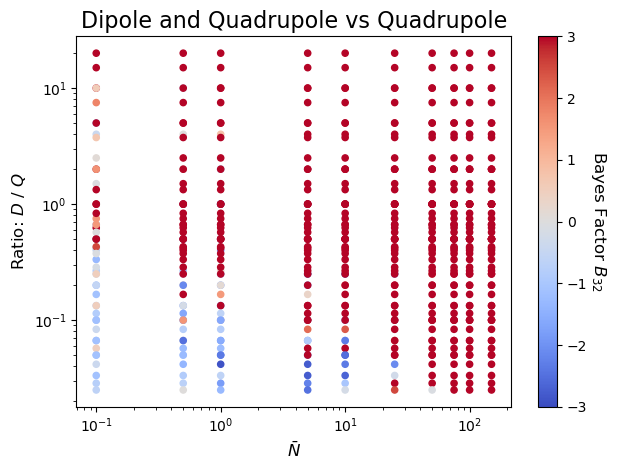

In [5]:
norm = mcolors.TwoSlopeNorm(vmin=-3, vcenter=0, vmax=3)
plt.scatter(B_32_df['Nbar'], B_32_df['D'] / B_32_df['Q'], c=B_32_df['bayes_factor'], cmap='coolwarm', s=20, norm=norm)
cbar = plt.colorbar()
cbar.set_label(r'Bayes Factor $B_{32}$', rotation=270, labelpad=15, fontsize=12)

plt.title(r'Dipole and Quadrupole vs Quadrupole', fontsize=16)
plt.xscale('log')
plt.xlabel(r'$\bar{N}$', fontsize=12)
plt.title
plt.ylabel(r'Ratio: $D\ /\ Q$', fontsize=12)
plt.yscale('log')
plt.tight_layout()
# plt.savefig('../Figures/Bayes_Factors_Dipole_and_Quadrupole_vs_Quadrupole_D_Q_ratio.png', dpi=300, bbox_inches='tight')
plt.show()

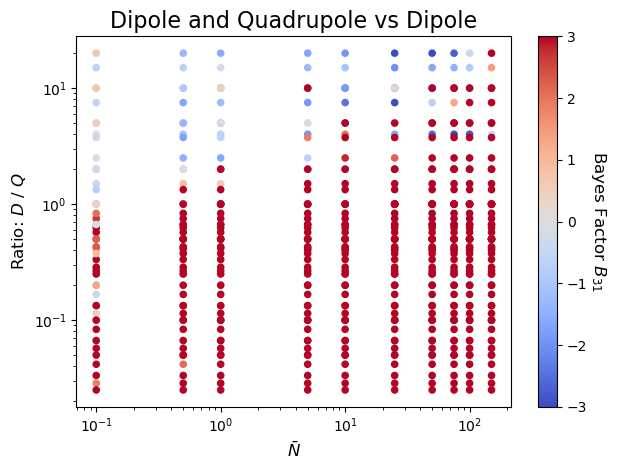

In [6]:
norm = mcolors.TwoSlopeNorm(vmin=-3, vcenter=0, vmax=3)
plt.scatter(B_31_df['Nbar'], B_31_df['D'] / B_31_df['Q'], c=B_31_df['bayes_factor'], cmap='coolwarm', s=20, norm=norm)
cbar = plt.colorbar()
cbar.set_label(r'Bayes Factor $B_{31}$', rotation=270, labelpad=15, fontsize=12)
plt.title(r'Dipole and Quadrupole vs Dipole', fontsize=16)
plt.xscale('log')
plt.xlabel(r'$\bar{N}$', fontsize=12)
plt.yscale('log')
plt.ylabel(r'Ratio: $D\ /\ Q$', fontsize=12)
plt.tight_layout()
# plt.savefig('../Figures/Bayes_Factors_Dipole_and_Quadrupole_vs_Dipole_D_Q_ratio.png', dpi=300, bbox_inches='tight')
plt.show()

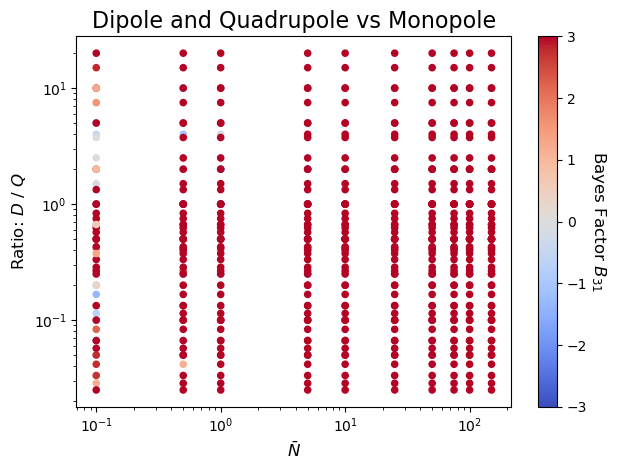

In [7]:
norm = mcolors.TwoSlopeNorm(vmin=-3, vcenter=0, vmax=3)
plt.scatter(B_30_df['Nbar'], B_30_df['D'] / B_30_df['Q'], c=B_30_df['bayes_factor'], cmap='coolwarm', s=20, norm=norm)
cbar = plt.colorbar()
cbar.set_label(r'Bayes Factor $B_{31}$', rotation=270, labelpad=15, fontsize=12)

plt.title(r'Dipole and Quadrupole vs Monopole', fontsize=16)
plt.xscale('log')
plt.xlabel(r'$\bar{N}$', fontsize=12)
plt.yscale('log')
plt.ylabel(r'Ratio: $D\ /\ Q$', fontsize=12)
plt.tight_layout()
# plt.savefig('../Figures/Bayes_Factors_Dipole_and_Quadrupole_vs_monopole_D_Q_ratio.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
Nbar_list = [0.1,0.5,1,5,10,25,50,75,100,150]
D_list = [0.005,0.01,0.02,0.05,0.075,0.1]
Q_list = [0.005,0.01,0.02,0.05,0.075,0.1,0.12,0.15,0.175,0.2]

# Nbar = B_32_df['Nbar'].values
# D = B_32_df['D'].values
# Q = B_32_df['Q'].values
# bayes_factor = B_32_df['bayes_factor'].values

# norm = mcolors.TwoSlopeNorm(vmin=-3, vcenter=0, vmax=5)


# for n in sorted(set(Nbar)):
#     mask = [nval == n for nval in Nbar]
#     plt.figure()
#     plt.scatter([D[i] for i in range(len(D)) if mask[i]],
#                 [Q[i] for i in range(len(Q)) if mask[i]],
#                 c=[bayes_factor[i] for i in range(len(bayes_factor)) if mask[i]],
#                 cmap='coolwarm', s=60, norm=norm)
#     cbar = plt.colorbar()
#     cbar.set_label(r'Bayes Factor $B_{32}$', rotation=270, labelpad=15, fontsize=12)

#     plt.title(f'M$_3$ vs M$_2$ : Nbar = {n}', fontsize=14)
#     plt.xlabel('D')
#     plt.ylabel('Q')
   
#     plt.tight_layout()
#     plt.show()

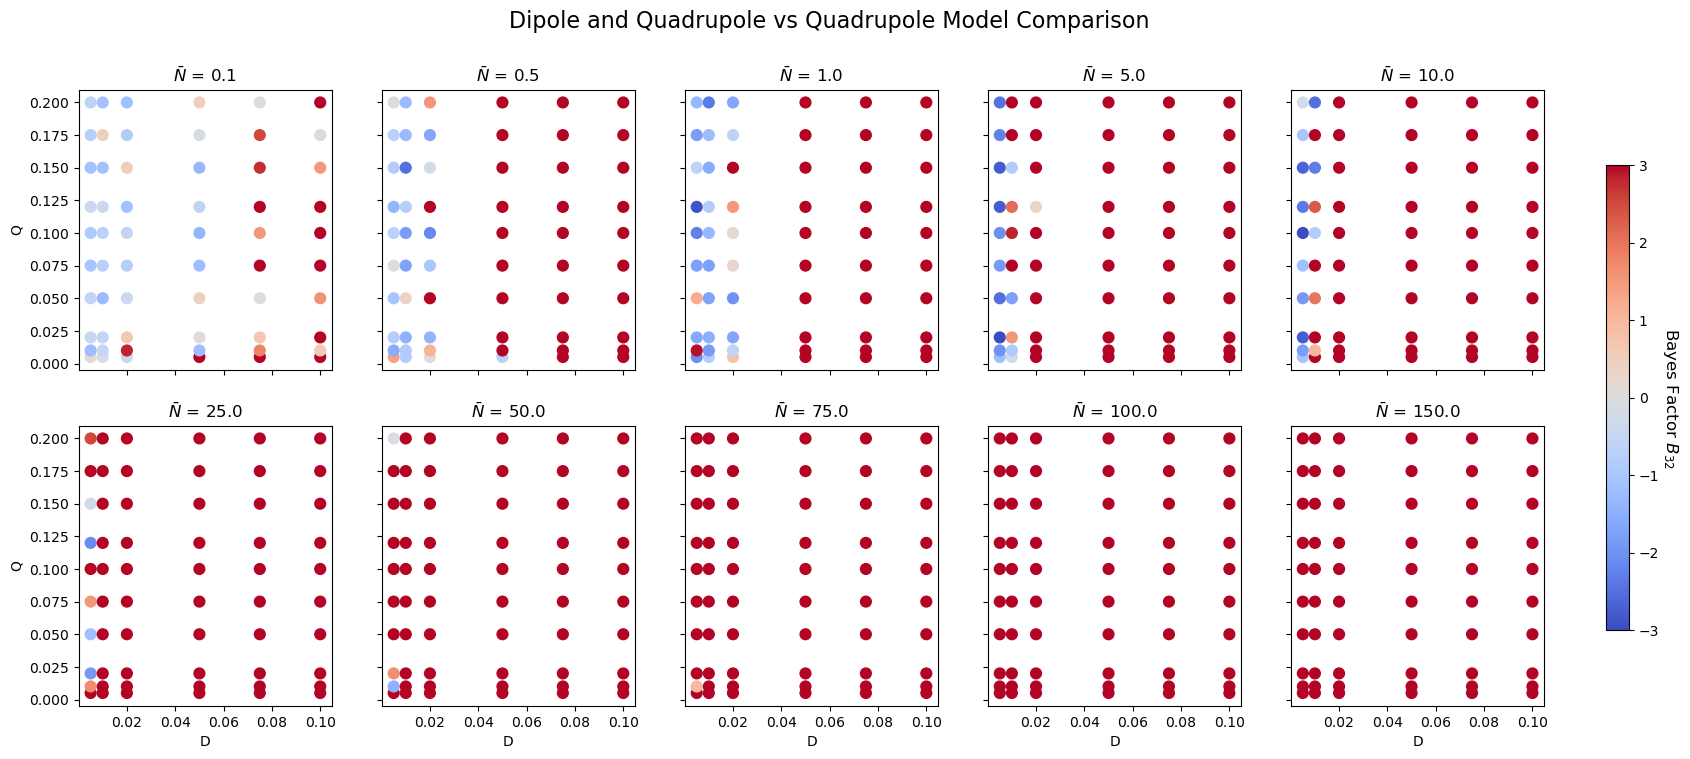

In [9]:
# Convert Series to numpy arrays
Nbar = B_32_df['Nbar'].values
D = B_32_df['D'].values
Q = B_32_df['Q'].values
bayes_factor = B_32_df['bayes_factor'].values

# Define colormap normalization
norm = mcolors.TwoSlopeNorm(vmin=-3, vcenter=0, vmax=3)

# Get sorted unique Nbar values
unique_nbar = sorted(set(Nbar))
n_panels = len(unique_nbar)

# Choose subplot layout
ncols = min(5, n_panels)
nrows = int(np.ceil(n_panels / ncols))

# Create figure and axes
fig, axs = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows), sharex=True, sharey=True)
axs = axs.flatten()
fig.suptitle(r'Dipole and Quadrupole vs Quadrupole Model Comparison', fontsize=16)

# Create scatter plots in subplots
for i, n in enumerate(unique_nbar):
    row = i // ncols
    col = i % ncols

    ax = axs[i]
    mask = (Nbar == n)

    sc = ax.scatter(D[mask], Q[mask], c=bayes_factor[mask],
                    cmap='coolwarm', s=60, norm=norm)

    ax.set_title(r'$\bar{N}$ = ' + str(n), fontsize=12)

    # Only show y-axis label on the first column
    if col == 0:
        ax.set_ylabel('Q')
    else:
        ax.set_ylabel('')
    
    # Only show x-axis label on the bottom row
    if row == nrows - 1:
        ax.set_xlabel('D')
    else:
        ax.set_xlabel('')

# Hide any unused axes
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Add one colorbar to the right
cbar = fig.colorbar(sc, ax=axs, orientation='vertical', fraction=0.015, pad=0.04)
cbar.set_label(r'Bayes Factor $B_{32}$', rotation=270, labelpad=15, fontsize=12)

# plt.tight_layout()
# plt.savefig('../Figures/Bayes_Factors_Dipole_and_Quadrupole_vs_Quadrupole.png', dpi=300, bbox_inches='tight')
plt.show()


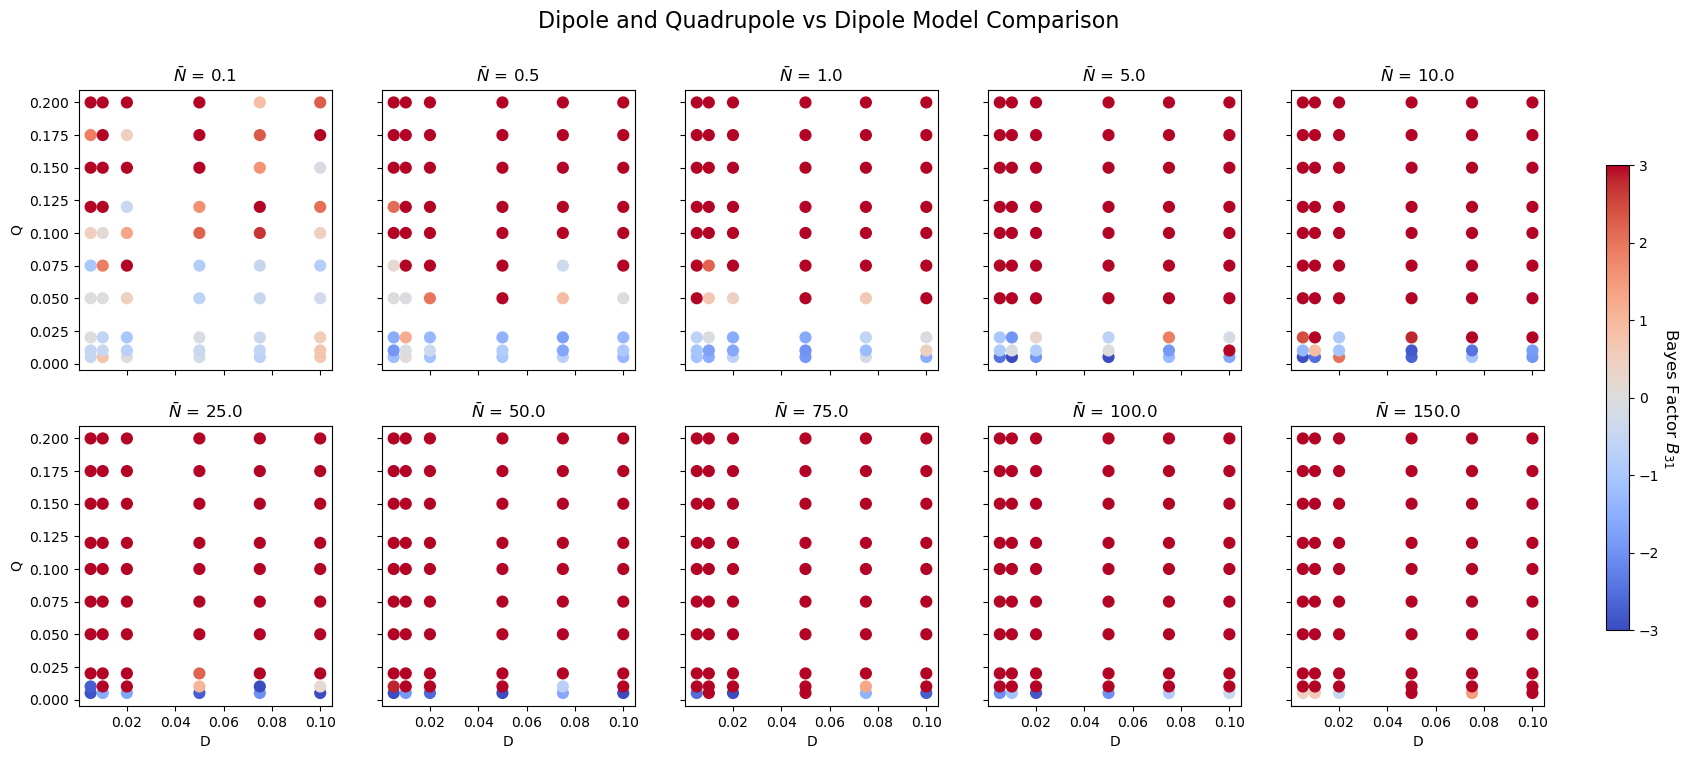

In [10]:
# Convert Series to numpy arrays
Nbar = B_31_df['Nbar'].values
D = B_31_df['D'].values
Q = B_31_df['Q'].values
bayes_factor = B_31_df['bayes_factor'].values

# Define colormap normalization
norm = mcolors.TwoSlopeNorm(vmin=-3, vcenter=0, vmax=3)

# Get sorted unique Nbar values
unique_nbar = sorted(set(Nbar))
n_panels = len(unique_nbar)

# Choose subplot layout
ncols = min(5, n_panels)
nrows = int(np.ceil(n_panels / ncols))

# Create figure and axes
fig, axs = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows), sharex=True, sharey=True)
axs = axs.flatten()
fig.suptitle(r'Dipole and Quadrupole vs Dipole Model Comparison', fontsize=16)

# Create scatter plots in subplots
for i, n in enumerate(unique_nbar):
    row = i // ncols
    col = i % ncols

    ax = axs[i]
    mask = (Nbar == n)

    sc = ax.scatter(D[mask], Q[mask], c=bayes_factor[mask],
                    cmap='coolwarm', s=60, norm=norm)

    ax.set_title(r'$\bar{N}$ = ' + str(n), fontsize=12)

    # Only show y-axis label on the first column
    if col == 0:
        ax.set_ylabel('Q')
    else:
        ax.set_ylabel('')
    
    # Only show x-axis label on the bottom row
    if row == nrows - 1:
        ax.set_xlabel('D')
    else:
        ax.set_xlabel('')

# Hide any unused axes
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Add one colorbar to the right
cbar = fig.colorbar(sc, ax=axs, orientation='vertical', fraction=0.015, pad=0.04)
cbar.set_label(r'Bayes Factor $B_{31}$', rotation=270, labelpad=15, fontsize=12)

# plt.tight_layout()
# plt.savefig('../Figures/Bayes_Factors_Dipole_and_Quadrupole_vs_Dipole.png', dpi=300, bbox_inches='tight')
plt.show()

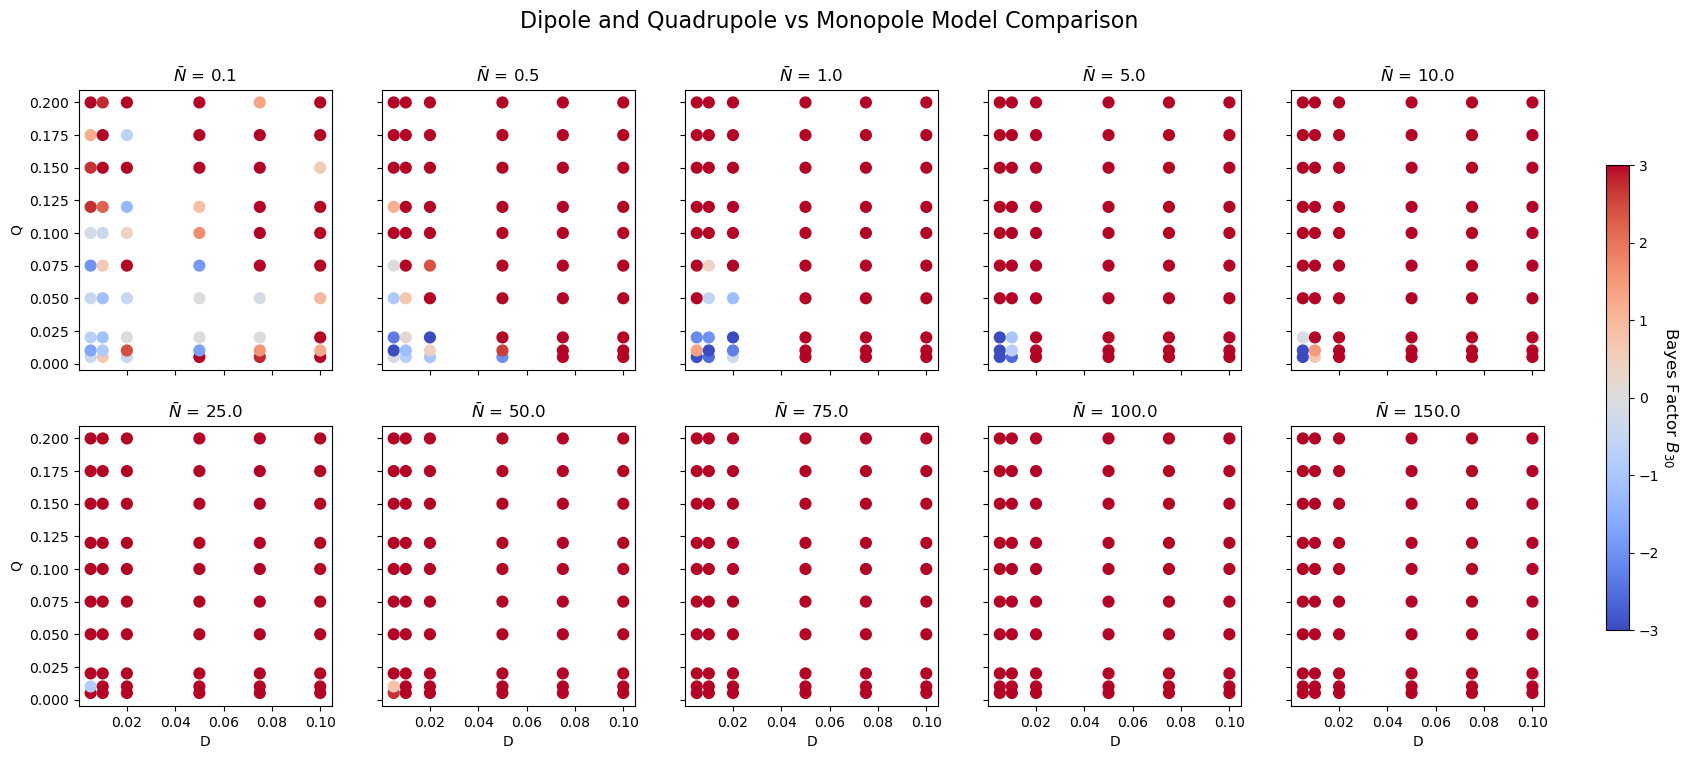

In [10]:
# Convert Series to numpy arrays
Nbar = B_30_df['Nbar'].values
D = B_30_df['D'].values
Q = B_30_df['Q'].values
bayes_factor = B_30_df['bayes_factor'].values

# Define colormap normalization
norm = mcolors.TwoSlopeNorm(vmin=-3, vcenter=0, vmax=3)

# Get sorted unique Nbar values
unique_nbar = sorted(set(Nbar))
n_panels = len(unique_nbar)

# Choose subplot layout
ncols = min(5, n_panels)
nrows = int(np.ceil(n_panels / ncols))

# Create figure and axes
fig, axs = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows), sharex=True, sharey=True)
axs = axs.flatten()
fig.suptitle(r'Dipole and Quadrupole vs Monopole Model Comparison', fontsize=16)

# Create scatter plots in subplots
for i, n in enumerate(unique_nbar):
    row = i // ncols
    col = i % ncols

    ax = axs[i]
    mask = (Nbar == n)

    sc = ax.scatter(D[mask], Q[mask], c=bayes_factor[mask],
                    cmap='coolwarm', s=60, norm=norm)

    ax.set_title(r'$\bar{N}$ = ' + str(n), fontsize=12)

    # Only show y-axis label on the first column
    if col == 0:
        ax.set_ylabel('Q')
    else:
        ax.set_ylabel('')
    
    # Only show x-axis label on the bottom row
    if row == nrows - 1:
        ax.set_xlabel('D')
    else:
        ax.set_xlabel('')

# Hide any unused axes
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Add one colorbar to the right
cbar = fig.colorbar(sc, ax=axs, orientation='vertical', fraction=0.015, pad=0.04)
cbar.set_label(r'Bayes Factor $B_{30}$', rotation=270, labelpad=15, fontsize=12)

# plt.tight_layout()
# plt.savefig('../Figures/Bayes_Factors_Dipole_and_Quadrupole_vs_Monopole.png', dpi=300, bbox_inches='tight')
plt.show()

# 3D Scatter plot

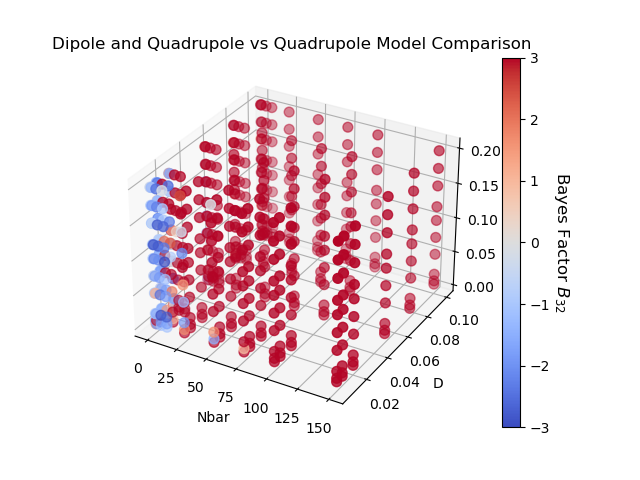

In [11]:
from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget
# %matplotlib inline
Nbar = B_32_df['Nbar'].values
D = B_32_df['D'].values
Q = B_32_df['Q'].values
bayes_factor = B_32_df['bayes_factor'].values
norm = mcolors.TwoSlopeNorm(vmin=-3, vcenter=0, vmax=3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(Nbar, D, Q, c=bayes_factor, cmap='coolwarm', s=50, norm=norm)
cbar = fig.colorbar(sc)
cbar.set_label(r'Bayes Factor $B_{32}$', rotation=270, labelpad=15, fontsize=12)


ax.set_xlabel('Nbar')
ax.set_ylabel('D')
ax.set_zlabel('Q')
plt.title('Dipole and Quadrupole vs Quadrupole Model Comparison')
# plt.tight_layout()
plt.show()

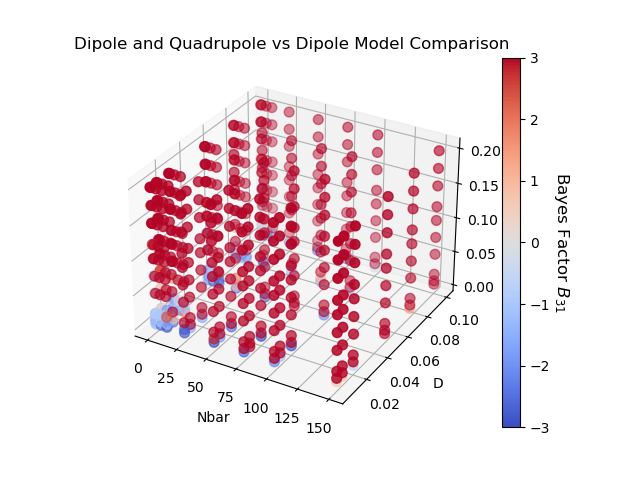

In [12]:
Nbar = B_31_df['Nbar'].values
D = B_31_df['D'].values
Q = B_31_df['Q'].values
bayes_factor = B_31_df['bayes_factor'].values
norm = mcolors.TwoSlopeNorm(vmin=-3, vcenter=0, vmax=3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(Nbar, D, Q, c=bayes_factor, cmap='coolwarm', s=50, norm=norm)
cbar = fig.colorbar(sc)
cbar.set_label(r'Bayes Factor $B_{31}$', rotation=270, labelpad=15, fontsize=12)


ax.set_xlabel('Nbar')
ax.set_ylabel('D')
ax.set_zlabel('Q')
plt.title('Dipole and Quadrupole vs Dipole Model Comparison')
# plt.tight_layout()
plt.show()

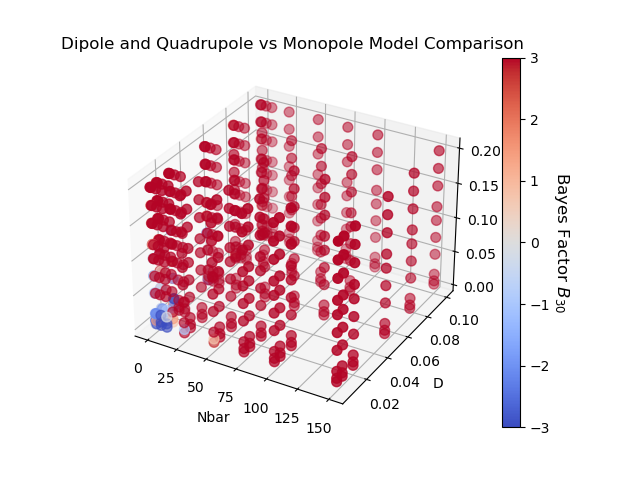

In [13]:
Nbar = B_30_df['Nbar'].values
D = B_30_df['D'].values
Q = B_30_df['Q'].values
bayes_factor = B_30_df['bayes_factor'].values

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(Nbar, D, Q, c=bayes_factor, cmap='coolwarm', s=50, norm=norm)
cbar = fig.colorbar(sc)
cbar.set_label(r'Bayes Factor $B_{30}$', rotation=270, labelpad=15, fontsize=12)


ax.set_xlabel('Nbar')
ax.set_ylabel('D')
ax.set_zlabel('Q')
plt.title('Dipole and Quadrupole vs Monopole Model Comparison')
# plt.tight_layout()
plt.show()

In [14]:
%matplotlib inline

# Heatmaps

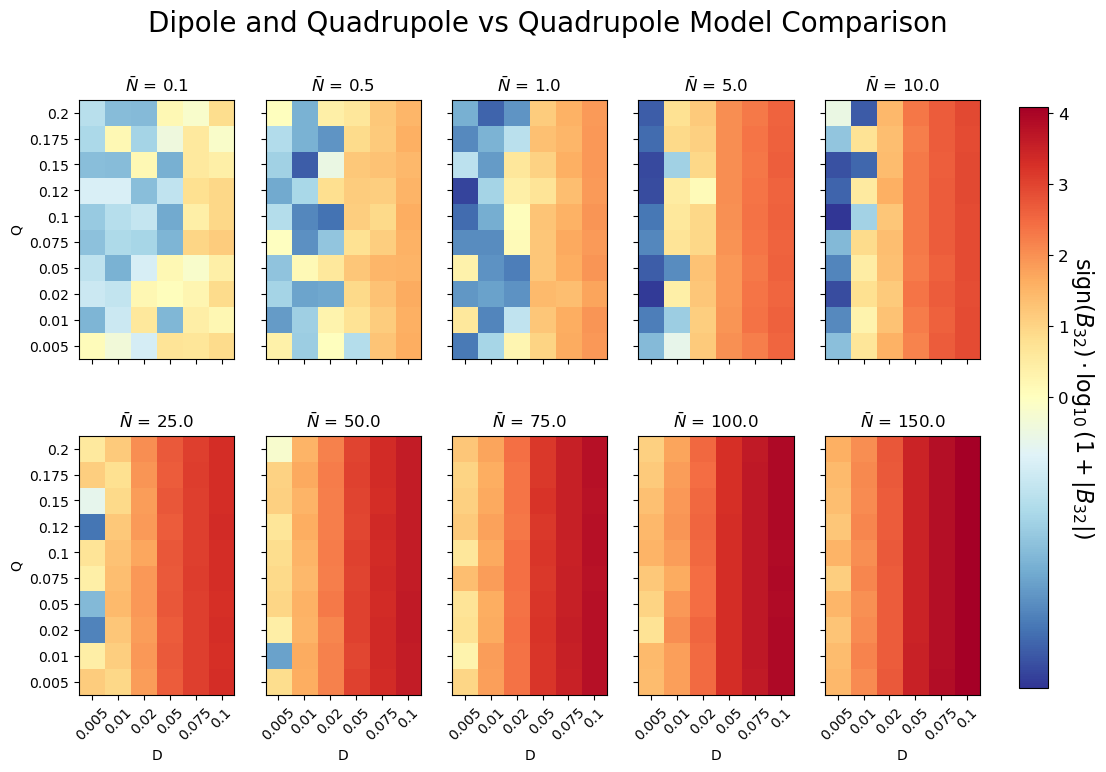

In [211]:
# Convert Series to numpy arrays
Nbar = B_32_df['Nbar'].values
D = B_32_df['D'].values
Q = B_32_df['Q'].values
bayes_factor = B_32_df['bayes_factor'].values

# Define the fixed D and Q grids
D_list = [0.005, 0.01, 0.02, 0.05, 0.075, 0.1]
Q_list = [0.005, 0.01, 0.02, 0.05, 0.075, 0.1, 0.12, 0.15, 0.175, 0.2]

# Create mapping from actual values to indices (even bin spacing)
D_indices = {d: i for i, d in enumerate(D_list)}
Q_indices = {q: i for i, q in enumerate(Q_list)}

# Normalize color scale
# norm = mcolors.TwoSlopeNorm(vmin=-3, vcenter=0, vmax=3)

# Unique Nbar values
unique_nbar = sorted(set(Nbar))
n_panels = len(unique_nbar)

# Layout
ncols = min(5, n_panels)
nrows = int(np.ceil(n_panels / ncols))

# Create subplots
fig, axs = plt.subplots(nrows, ncols, figsize=(2.5 * ncols, 4 * nrows), sharex=True, sharey=True)
axs = axs.flatten()


fig.suptitle(r'Dipole and Quadrupole vs Quadrupole Model Comparison', fontsize=20)

# --- Define signed log transform ---
def signed_log(x, eps=1e-0):
    return np.sign(x) * np.log10(1 + np.abs(x)/eps)

# Apply transform to all data up front to get color scaling
bayes_factor_log = signed_log(bayes_factor)
vmax = np.max(np.abs(bayes_factor_log))
vmin = np.min(bayes_factor_log)
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

for i, n in enumerate(unique_nbar):
    ax = axs[i]

    # Filter for current Nbar
    mask = (Nbar == n)
    D_n = D[mask]
    Q_n = Q[mask]
    BF_n = bayes_factor[mask]

    # Initialize heatmap
    heatmap = np.full((len(Q_list), len(D_list)), np.nan)
    for d_val, q_val, bf in zip(D_n, Q_n, BF_n):
        if d_val in D_indices and q_val in Q_indices:
            bf_log = signed_log(bf) # adding for the log transform
            heatmap[Q_indices[q_val], D_indices[d_val]] = bf_log # added _log to bf

    # Show image
    im = ax.imshow(
        heatmap,
        origin='lower',
        aspect='equal',
        cmap='RdYlBu_r',
        norm=norm,
        extent=[0, len(D_list), 0, len(Q_list)]
    )

    ax.set_title(r'$\bar{N}$ = ' + str(n), fontsize=12)

    # Ticks at bin centers
    ax.set_xticks(np.arange(len(D_list)) + 0.5)
    ax.set_xticklabels(D_list, rotation=45)

    # Always show y tick labels
    ax.set_yticks(np.arange(len(Q_list)) + 0.5)
    ax.set_yticklabels(Q_list)

    # Add axis labels only to left and bottom
    if i % ncols == 0:
        ax.set_ylabel('Q')

    if i >= n_panels - ncols:
        ax.set_xlabel('D')
    else:
        ax.set_xticklabels([])
    
# Remove unused axes
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Shared colorbar
cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.03, pad=0.04)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'$\mathrm{sign}(B_{32}) \cdot \log_{10}(1 + |B_{32}|)$', rotation=270, labelpad=20, fontsize=16)

# plt.tight_layout()
# plt.savefig('../Figures/Bayes_Factors_Heatmap_DQ_vs_Q_by_Nbar.png', dpi=300, bbox_inches='tight')
plt.show()

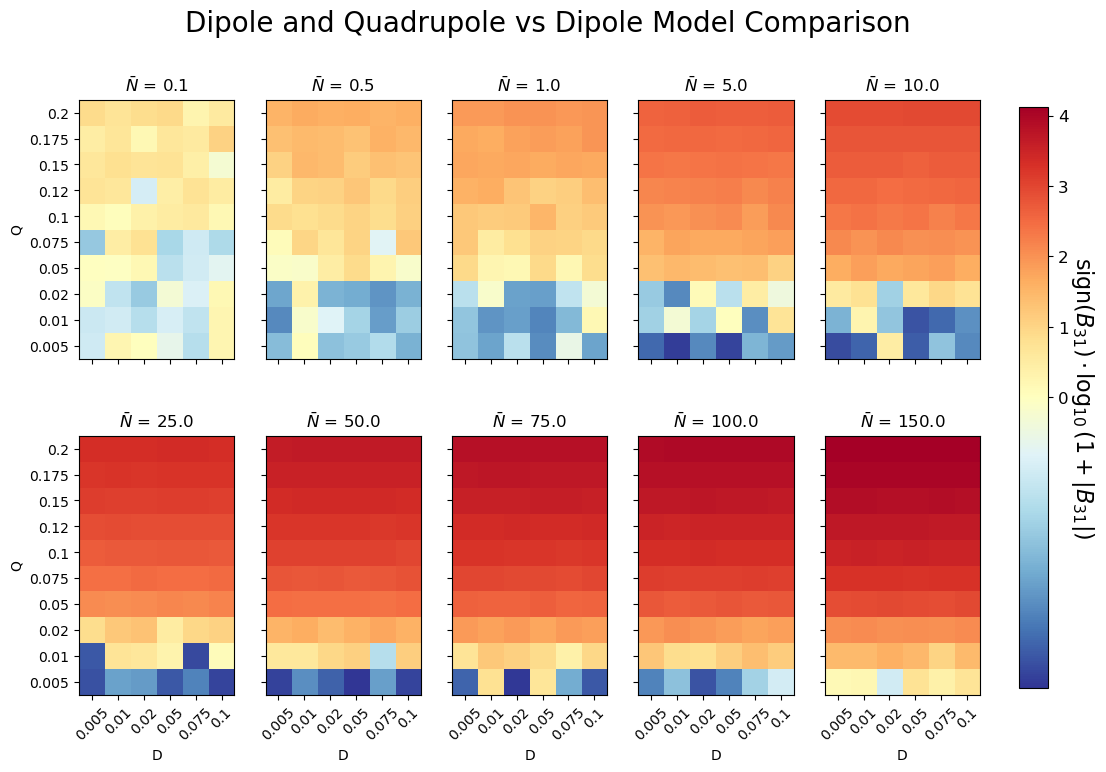

In [212]:
# Convert Series to numpy arrays
Nbar = B_31_df['Nbar'].values
D = B_31_df['D'].values
Q = B_31_df['Q'].values
bayes_factor = B_31_df['bayes_factor'].values

# Define the fixed D and Q grids
D_list = [0.005, 0.01, 0.02, 0.05, 0.075, 0.1]
Q_list = [0.005, 0.01, 0.02, 0.05, 0.075, 0.1, 0.12, 0.15, 0.175, 0.2]

# Create mapping from actual values to indices (even bin spacing)
D_indices = {d: i for i, d in enumerate(D_list)}
Q_indices = {q: i for i, q in enumerate(Q_list)}

# Normalize color scale
norm = mcolors.TwoSlopeNorm(vmin=-3, vcenter=0, vmax=3)

# Unique Nbar values
unique_nbar = sorted(set(Nbar))
n_panels = len(unique_nbar)

# Layout
ncols = min(5, n_panels)
nrows = int(np.ceil(n_panels / ncols))

# Create subplots
fig, axs = plt.subplots(nrows, ncols, figsize=(2.5 * ncols, 4 * nrows), sharex=True, sharey=True)
axs = axs.flatten()

fig.suptitle(r'Dipole and Quadrupole vs Dipole Model Comparison', fontsize=20)

# --- Define signed log transform ---
def signed_log(x, eps=1e-0):
    return np.sign(x) * np.log10(1 + np.abs(x)/eps)

# Apply transform to all data up front to get color scaling
bayes_factor_log = signed_log(bayes_factor)
vmax = np.max(np.abs(bayes_factor_log))
vmin = np.min(bayes_factor_log)
norm = mcolors.TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

for i, n in enumerate(unique_nbar):
    ax = axs[i]

    # Filter for current Nbar
    mask = (Nbar == n)
    D_n = D[mask]
    Q_n = Q[mask]
    BF_n = bayes_factor[mask]

    # Initialize heatmap
    heatmap = np.full((len(Q_list), len(D_list)), np.nan)
    for d_val, q_val, bf in zip(D_n, Q_n, BF_n):
        if d_val in D_indices and q_val in Q_indices:
            bf_log = signed_log(bf)
            heatmap[Q_indices[q_val], D_indices[d_val]] = bf_log

    # Show image
    im = ax.imshow(
        heatmap,
        origin='lower',
        aspect='equal',
        cmap='RdYlBu_r',
        norm=norm,
        extent=[0, len(D_list), 0, len(Q_list)]
    )

    ax.set_title(r'$\bar{N}$ = ' + str(n), fontsize=12)

    # Ticks at bin centers
    ax.set_xticks(np.arange(len(D_list)) + 0.5)
    ax.set_xticklabels(D_list, rotation=45)

    # Always show y tick labels
    ax.set_yticks(np.arange(len(Q_list)) + 0.5)
    ax.set_yticklabels(Q_list)

    # Add axis labels only to left and bottom
    if i % ncols == 0:
        ax.set_ylabel('Q')

    if i >= n_panels - ncols:
        ax.set_xlabel('D')
    else:
        ax.set_xticklabels([])

# Remove unused axes
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Shared colorbar
cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.03, pad=0.04)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'$\mathrm{sign}(B_{31}) \cdot \log_{10}(1 + |B_{31}|)$', rotation=270, labelpad=20, fontsize=16)

# plt.tight_layout()
# plt.savefig('../Figures/Bayes_Factors_Heatmap_DQ_vs_D_by_Nbar.png', dpi=300, bbox_inches='tight')
plt.show()


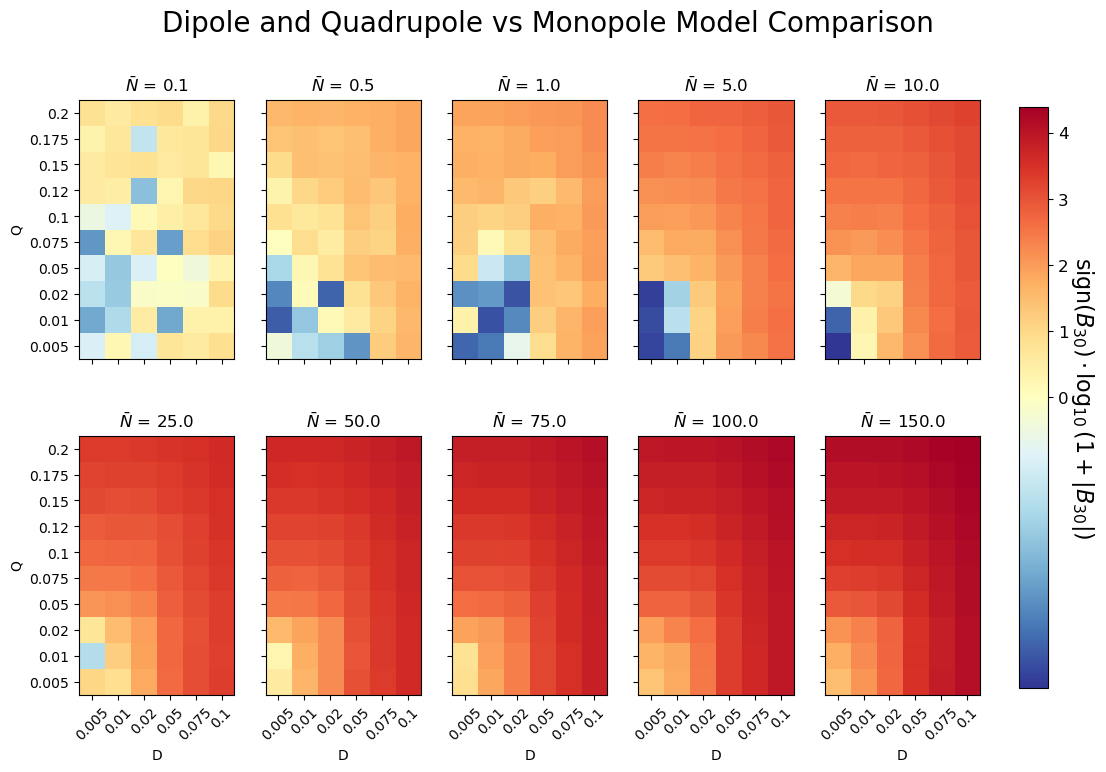

In [213]:
# Convert Series to numpy arrays
Nbar = B_30_df['Nbar'].values
D = B_30_df['D'].values
Q = B_30_df['Q'].values
bayes_factor = B_30_df['bayes_factor'].values

# Define the fixed D and Q grids
D_list = [0.005, 0.01, 0.02, 0.05, 0.075, 0.1]
Q_list = [0.005, 0.01, 0.02, 0.05, 0.075, 0.1, 0.12, 0.15, 0.175, 0.2]

# Create mapping from actual values to indices (even bin spacing)
D_indices = {d: i for i, d in enumerate(D_list)}
Q_indices = {q: i for i, q in enumerate(Q_list)}

# Normalize color scale
norm = mcolors.TwoSlopeNorm(vmin=-3, vcenter=0, vmax=3)

# Unique Nbar values
unique_nbar = sorted(set(Nbar))
n_panels = len(unique_nbar)

# Layout
ncols = min(5, n_panels)
nrows = int(np.ceil(n_panels / ncols))

# Create subplots
fig, axs = plt.subplots(nrows, ncols, figsize=(2.5 * ncols, 4 * nrows), sharex=True, sharey=True)
axs = axs.flatten()


fig.suptitle(r'Dipole and Quadrupole vs Monopole Model Comparison', fontsize=20)

# --- Define signed log transform ---
def signed_log(x, eps=1e-0):
    return np.sign(x) * np.log10(1 + np.abs(x)/eps)

# Apply transform to all data up front to get color scaling
bayes_factor_log = signed_log(bayes_factor)
vmax = np.max(np.abs(bayes_factor_log))
vmin = np.min(bayes_factor_log)
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

for i, n in enumerate(unique_nbar):
    ax = axs[i]

    # Filter for current Nbar
    mask = (Nbar == n)
    D_n = D[mask]
    Q_n = Q[mask]
    BF_n = bayes_factor[mask]

    # Initialize heatmap
    heatmap = np.full((len(Q_list), len(D_list)), np.nan)
    for d_val, q_val, bf in zip(D_n, Q_n, BF_n):
        if d_val in D_indices and q_val in Q_indices:
            bf_log = signed_log(bf)
            heatmap[Q_indices[q_val], D_indices[d_val]] = bf_log

    # Show image
    im = ax.imshow(
        heatmap,
        origin='lower',
        aspect='equal',
        cmap='RdYlBu_r',
        norm=norm,
        extent=[0, len(D_list), 0, len(Q_list)]
    )

    ax.set_title(r'$\bar{N}$ = ' + str(n), fontsize=12)

    # Ticks at bin centers
    ax.set_xticks(np.arange(len(D_list)) + 0.5)
    ax.set_xticklabels(D_list, rotation=45)

    # Always show y tick labels
    ax.set_yticks(np.arange(len(Q_list)) + 0.5)
    ax.set_yticklabels(Q_list)

    # Add axis labels only to left and bottom
    if i % ncols == 0:
        ax.set_ylabel('Q')

    if i >= n_panels - ncols:
        ax.set_xlabel('D')
    else:
        ax.set_xticklabels([])

# Remove unused axes
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Shared colorbar
cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.03, pad=0.04)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'$\mathrm{sign}(B_{30}) \cdot \log_{10}(1 + |B_{30}|)$', rotation=270, labelpad=20, fontsize=16)

# plt.tight_layout()
# plt.savefig('../Figures/Bayes_Factors_Heatmap_DQ_vs_M_by_Nbar.png', dpi=300, bbox_inches='tight')
plt.show()

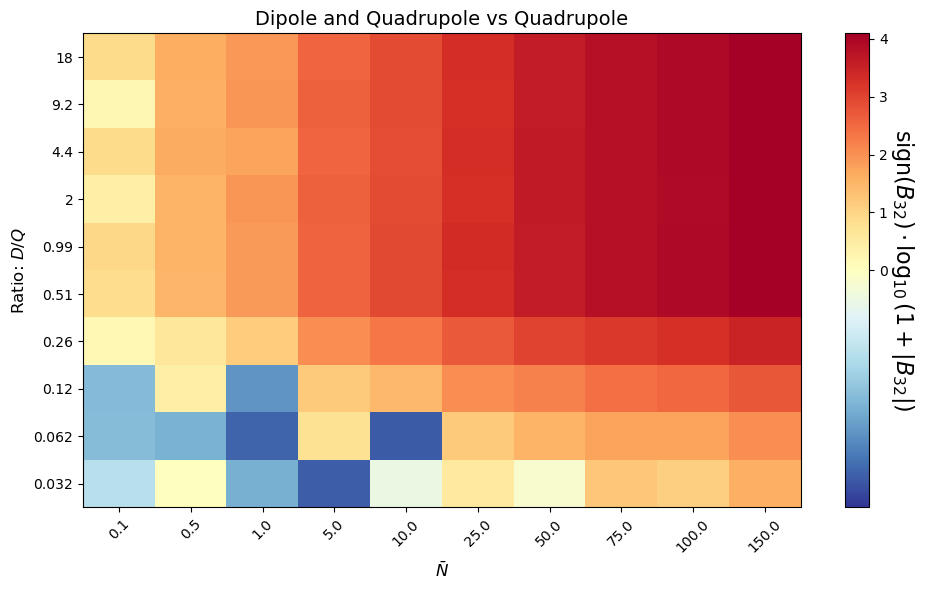

In [214]:
# Extract values
Nbar = B_32_df['Nbar'].values
DQ_ratio = (B_32_df['D'] / B_32_df['Q']).values
normalised_DQ_ratio = (DQ_ratio / np.max(DQ_ratio)) 
# DQ_ratio = normalised_DQ_ratio

bayes_factor = B_32_df['bayes_factor'].values

# Sort unique Nbar values for even binning along x-axis
unique_nbar = sorted(set(Nbar))
Nbar_indices = {n: i for i, n in enumerate(unique_nbar)}

# Define log-spaced ratio bins (y-axis)
num_ratio_bins = 10
DQ_bins = np.logspace(np.log10(min(DQ_ratio)), np.log10(max(DQ_ratio)), num_ratio_bins + 1)

# Initialize heatmap
heatmap = np.full((num_ratio_bins, len(unique_nbar)), np.nan)

# To store all ratios per bin (for computing average labels)
ratio_bin_values = [[] for _ in range(num_ratio_bins)]

# Fill heatmap and collect ratios
for n, dq, bf in zip(Nbar, DQ_ratio, bayes_factor):
    x_idx = Nbar_indices[n]
    y_idx = np.digitize(dq, DQ_bins) - 1
    if 0 <= y_idx < num_ratio_bins:
        bf_log = signed_log(bf)  # Apply signed log transform
        heatmap[y_idx, x_idx] = bf_log
        ratio_bin_values[y_idx].append(dq)

# Calculate average ratio per bin (for tick labels)
DQ_bin_labels = [
    np.mean(vals) if vals else 0  # avoid empty bins
    for vals in ratio_bin_values
]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
norm = mcolors.TwoSlopeNorm(vmin=-3, vcenter=0, vmax=3)

# --- Define signed log transform ---
def signed_log(x, eps=1e-0):
    return np.sign(x) * np.log10(1 + np.abs(x)/eps)

# Apply transform to all data up front to get color scaling
bayes_factor_log = signed_log(bayes_factor)
vmax = np.max(np.abs(bayes_factor_log))
vmin = np.min(bayes_factor_log)
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

im = ax.imshow(
    heatmap,
    origin='lower',
    aspect='auto',
    cmap='RdYlBu_r',
    norm=norm,
    extent=[0, len(unique_nbar), 0, num_ratio_bins]
)

# X-axis: Nbar
ax.set_xticks(np.arange(len(unique_nbar)) + 0.5)
ax.set_xticklabels(unique_nbar, rotation=45)
ax.set_xlabel(r'$\bar{N}$', fontsize=12)

# Y-axis: D/Q ratio bins
ax.set_yticks(np.arange(num_ratio_bins) + 0.5)
ax.set_yticklabels([f"{val:0.2g}" if val > 0 else "" for val in DQ_bin_labels])
ax.set_ylabel(r'Ratio: $D / Q$', fontsize=12)

# Title
ax.set_title(r'Dipole and Quadrupole vs Quadrupole', fontsize=14)

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label(r'$\mathrm{sign}(B_{32}) \cdot \log_{10}(1 + |B_{32}|)$', rotation=270, labelpad=20, fontsize=16)

plt.tight_layout()
# plt.savefig('../Figures/Bayes_Factors_Heatmap_Dipole_and_Quadrupole_vs_Quadrupole_DQ_ratio.png', dpi=300, bbox_inches='tight')
plt.show()

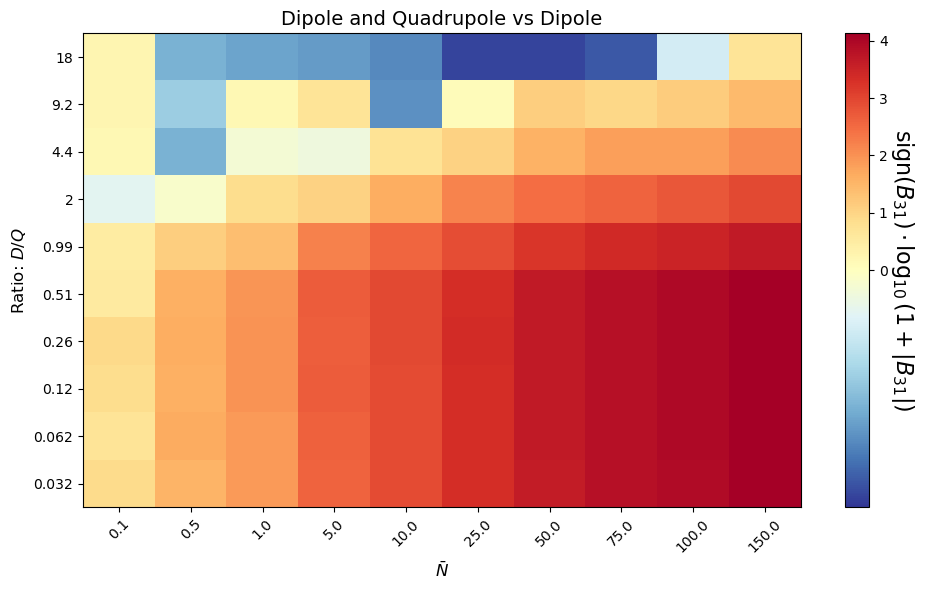

In [215]:
# Extract values
Nbar = B_31_df['Nbar'].values
DQ_ratio = (B_31_df['D'] / B_31_df['Q']).values
normalised_DQ_ratio = (DQ_ratio / np.max(DQ_ratio)) 
# DQ_ratio = normalised_DQ_ratio

bayes_factor = B_31_df['bayes_factor'].values

# Sort unique Nbar values for even binning along x-axis
unique_nbar = sorted(set(Nbar))
Nbar_indices = {n: i for i, n in enumerate(unique_nbar)}

# Define log-spaced ratio bins (y-axis)
num_ratio_bins = 10
DQ_bins = np.logspace(np.log10(min(DQ_ratio)), np.log10(max(DQ_ratio)), num_ratio_bins + 1)

# Initialize heatmap
heatmap = np.full((num_ratio_bins, len(unique_nbar)), np.nan)

# To store all ratios per bin (for computing average labels)
ratio_bin_values = [[] for _ in range(num_ratio_bins)]

# Fill heatmap and collect ratios
for n, dq, bf in zip(Nbar, DQ_ratio, bayes_factor):
    x_idx = Nbar_indices[n]
    y_idx = np.digitize(dq, DQ_bins) - 1
    if 0 <= y_idx < num_ratio_bins:
        bf_log = signed_log(bf)
        heatmap[y_idx, x_idx] = bf_log
        ratio_bin_values[y_idx].append(dq)

# Calculate average ratio per bin (for tick labels)
DQ_bin_labels = [
    np.mean(vals) if vals else 0  # avoid empty bins
    for vals in ratio_bin_values
]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
norm = mcolors.TwoSlopeNorm(vmin=-3, vcenter=0, vmax=3)

# --- Define signed log transform ---
def signed_log(x, eps=1e-0):
    return np.sign(x) * np.log10(1 + np.abs(x)/eps)

# Apply transform to all data up front to get color scaling
bayes_factor_log = signed_log(bayes_factor)
vmax = np.max(np.abs(bayes_factor_log))
vmin = np.min(bayes_factor_log)
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

im = ax.imshow(
    heatmap,
    origin='lower',
    aspect='auto',
    cmap='RdYlBu_r',
    norm=norm,
    extent=[0, len(unique_nbar), 0, num_ratio_bins]
)

# X-axis: Nbar
ax.set_xticks(np.arange(len(unique_nbar)) + 0.5)
ax.set_xticklabels(unique_nbar, rotation=45)
ax.set_xlabel(r'$\bar{N}$', fontsize=12)

# Y-axis: D/Q ratio bins
ax.set_yticks(np.arange(num_ratio_bins) + 0.5)
ax.set_yticklabels([f"{val:0.2g}" if val > 0 else "" for val in DQ_bin_labels])
ax.set_ylabel(r'Ratio: $D / Q$', fontsize=12)

# Title
ax.set_title(r'Dipole and Quadrupole vs Dipole', fontsize=14)

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label(r'$\mathrm{sign}(B_{31}) \cdot \log_{10}(1 + |B_{31}|)$', rotation=270, labelpad=20, fontsize=16)

plt.tight_layout()
# plt.savefig('../Figures/Bayes_Factors_Heatmap_Dipole_and_Quadrupole_vs_Dipole_DQ_ratio.png', dpi=300, bbox_inches='tight')
plt.show()

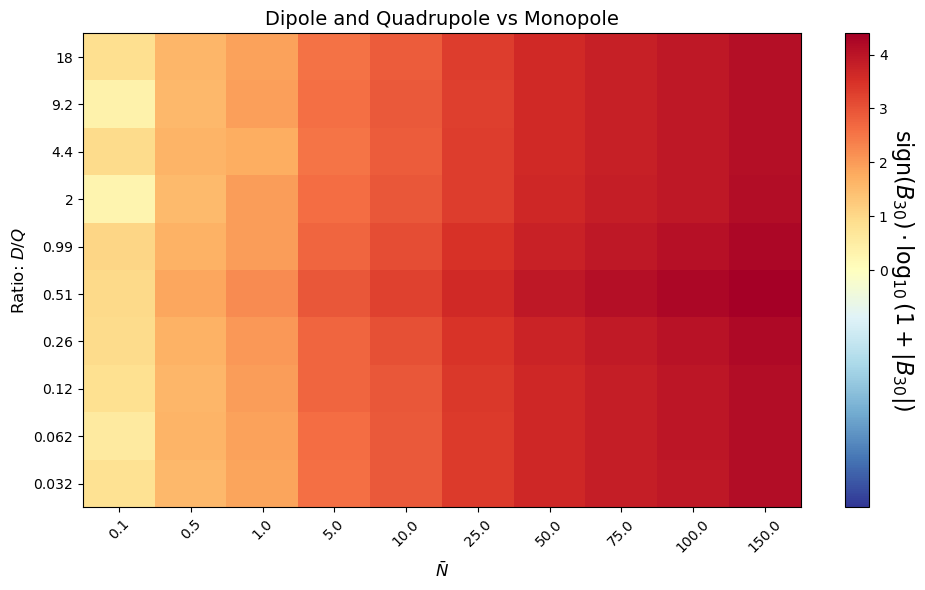

In [216]:
# Extract values
Nbar = B_30_df['Nbar'].values
DQ_ratio = (B_30_df['D'] / B_30_df['Q']).values
normalised_DQ_ratio = (DQ_ratio / np.max(DQ_ratio)) 
# DQ_ratio = normalised_DQ_ratio

bayes_factor = B_30_df['bayes_factor'].values

# Sort unique Nbar values for even binning along x-axis
unique_nbar = sorted(set(Nbar))
Nbar_indices = {n: i for i, n in enumerate(unique_nbar)}

# Define log-spaced ratio bins (y-axis)
num_ratio_bins = 10
DQ_bins = np.logspace(np.log10(min(DQ_ratio)), np.log10(max(DQ_ratio)), num_ratio_bins + 1)

# Initialize heatmap
heatmap = np.full((num_ratio_bins, len(unique_nbar)), np.nan)

# To store all ratios per bin (for computing average labels)
ratio_bin_values = [[] for _ in range(num_ratio_bins)]

# Fill heatmap and collect ratios
for n, dq, bf in zip(Nbar, DQ_ratio, bayes_factor):
    x_idx = Nbar_indices[n]
    y_idx = np.digitize(dq, DQ_bins) - 1
    if 0 <= y_idx < num_ratio_bins:
        bf_log = signed_log(bf)
        heatmap[y_idx, x_idx] = bf_log
        ratio_bin_values[y_idx].append(dq)

# Calculate average ratio per bin (for tick labels)
DQ_bin_labels = [
    np.mean(vals) if vals else 0  # avoid empty bins
    for vals in ratio_bin_values
]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
norm = mcolors.TwoSlopeNorm(vmin=-3, vcenter=0, vmax=3)

# --- Define signed log transform ---
def signed_log(x, eps=1e-0):
    return np.sign(x) * np.log10(1 + np.abs(x)/eps)

# Apply transform to all data up front to get color scaling
bayes_factor_log = signed_log(bayes_factor)
vmax = np.max(np.abs(bayes_factor_log))
vmin = np.min(bayes_factor_log)
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

im = ax.imshow(
    heatmap,
    origin='lower',
    aspect='auto',
    cmap='RdYlBu_r',
    norm=norm,
    extent=[0, len(unique_nbar), 0, num_ratio_bins]
)

# X-axis: Nbar
ax.set_xticks(np.arange(len(unique_nbar)) + 0.5)
ax.set_xticklabels(unique_nbar, rotation=45)
ax.set_xlabel(r'$\bar{N}$', fontsize=12)

# Y-axis: D/Q ratio bins
ax.set_yticks(np.arange(num_ratio_bins) + 0.5)
ax.set_yticklabels([f"{val:0.2g}" if val > 0 else "" for val in DQ_bin_labels])
ax.set_ylabel(r'Ratio: $D / Q$', fontsize=12)

# Title
ax.set_title(r'Dipole and Quadrupole vs Monopole', fontsize=14)

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label(r'$\mathrm{sign}(B_{30}) \cdot \log_{10}(1 + |B_{30}|)$', rotation=270, labelpad=20, fontsize=16)

plt.tight_layout()
# plt.savefig('../Figures/Bayes_Factors_Heatmap_Dipole_and_Quadrupole_vs_Monopole_DQ_ratio.png', dpi=300, bbox_inches='tight')
plt.show()

# Now, consider how the inferred amplitude of D and Q changes with Nbar, the true D, true Q and what the Bayes factor is. 

### read in the data, saving the predicted values

In [21]:
pathname = '../log_dir/Dipole_and_Quadrupole_Data/'
folders = ['monopole_model/', 'dipole_model/', 'quadrupole_model/', 'dipole_quadrupole_model/']

# dataframe = pd.DataFrame(columns=['model','Nbar', 'D', 'Q', 'evidence'])
global_df = pd.DataFrame(columns=['Nbar', 'D', 'Q', 'l', 'b', 'l1', 'b1', 'l2', 'b2', 'model', 'Nbar_true', 'D_true', 'Q_true'])

for folder in folders:
    folder_path = os.path.join(pathname, folder)
    
    # Only walk the immediate subdirectories of folder_path
    for root, subdirs, _ in os.walk(folder_path):
        for subfolder in subdirs:
            # remove subfolder that ends in times
            if subfolder.endswith('times'):
                continue

            file_path = os.path.join(root, subfolder, 'chains/equal_weighted_post.txt') # this is the path to the UN run folder
            
            with open(file_path, 'r') as f:
                splits = subfolder.split('_')
                Q_true = splits[-1]
                D_true = splits[-3]
                Nbar_true = splits[-5]
                if len(splits) == 8:
                    model = 'dipole_quadrupole'
                else:
                    model = splits[0]
                
                            # Assign correct columns for each model
                if model == 'monopole':
                    columns = ['Nbar']
                elif model == 'dipole':
                    columns = ['Nbar', 'D', 'l', 'b']
                elif model == 'quadrupole':
                    columns = ['Nbar', 'Q', 'l1', 'b1', 'l2', 'b2']
                elif model == 'dipole_quadrupole':
                    columns = ['Nbar', 'D', 'Q', 'l', 'b', 'l1', 'b1', 'l2', 'b2']
                else:
                    raise ValueError(f"Unknown model: {model}")
                
                df = pd.read_csv(file_path, delim_whitespace=True, header=None, skiprows=1, names=columns)

                last_row = df.iloc[[-1]].copy()
                last_row = last_row.astype(float)
                last_row['model'], last_row['Nbar_true'], last_row['D_true'], last_row['Q_true'] = model, float(Nbar_true), float(D_true), float(Q_true)
                global_df = pd.concat([global_df, last_row], ignore_index=True)

                
                # break

        break  # Prevent descending into deeper levels


In [22]:
global_df

,Nbar,D,Q,l,b,l1,b1,l2,b2,model,Nbar_true,D_true,Q_true
0,149.963583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,monopole,150.0,0.100,0.075
1,100.069270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,monopole,100.0,0.100,0.005
2,0.998309,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,monopole,1.0,0.005,0.150
3,9.980614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,monopole,10.0,0.050,0.010
4,4.974352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,monopole,5.0,0.100,0.120
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,49.933681,0.098949,0.001935,4.619851,0.840729,2.671494,0.715965,6.061108,1.764845,dipole_quadrupole,50.0,0.100,0.005
2396,49.980862,0.074512,0.004788,4.635677,0.839733,5.041608,2.879610,3.053302,1.705824,dipole_quadrupole,50.0,0.075,0.010
2397,99.939885,0.004998,0.012663,4.848002,0.792258,6.088657,2.586952,2.273972,1.189234,dipole_quadrupole,100.0,0.005,0.010
2398,74.946543,0.020184,0.050917,4.612096,0.885116,2.294495,0.514679,5.590159,2.081992,dipole_quadrupole,75.0,0.020,0.050


In [23]:
global_df.to_csv('../log_dir/Dipole_and_Quadrupole_Data/inferred_parameters.csv', index=False)

In [4]:
# read in the inferred parameters
global_df = pd.read_csv('../log_dir/Dipole_and_Quadrupole_Data/inferred_parameters.csv')
global_df

,Nbar,D,Q,l,b,l1,b1,l2,b2,model,Nbar_true,D_true,Q_true
0,149.963583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,monopole,150.0,0.100,0.075
1,100.069270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,monopole,100.0,0.100,0.005
2,0.998309,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,monopole,1.0,0.005,0.150
3,9.980614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,monopole,10.0,0.050,0.010
4,4.974352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,monopole,5.0,0.100,0.120
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,49.933681,0.098949,0.001935,4.619851,0.840729,2.671494,0.715965,6.061108,1.764845,dipole_quadrupole,50.0,0.100,0.005
2396,49.980862,0.074512,0.004788,4.635677,0.839733,5.041608,2.879610,3.053302,1.705824,dipole_quadrupole,50.0,0.075,0.010
2397,99.939885,0.004998,0.012663,4.848002,0.792258,6.088657,2.586952,2.273972,1.189234,dipole_quadrupole,100.0,0.005,0.010
2398,74.946543,0.020184,0.050917,4.612096,0.885116,2.294495,0.514679,5.590159,2.081992,dipole_quadrupole,75.0,0.020,0.050


In [136]:
monopole_df = global_df[global_df['model'] == 'monopole']
dipole_df = global_df[global_df['model'] == 'dipole']
quadrupole_df = global_df[global_df['model'] == 'quadrupole']
dipole_quadrupole_df = global_df[global_df['model'] == 'dipole_quadrupole']

# Residual plots for D and Q

/var/folders/6n/jy8tb_5j3zxfx6q51nz1tvr40000gn/T/ipykernel_29892/2791090537.py:15: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axhline(0, color='k', linestyle='--', linewidth=1)


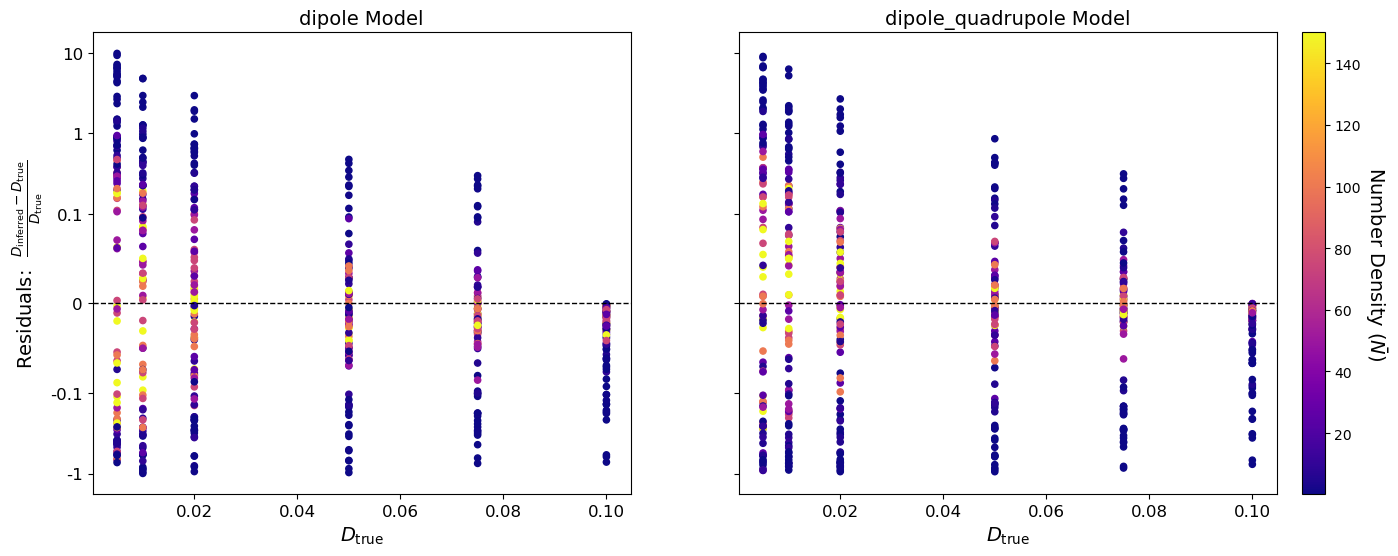

In [137]:

dataframes = [dipole_df, dipole_quadrupole_df]
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

for ax, data in zip(axes, dataframes):
    sc = ax.scatter(
        data['D_true'],
        (data['D'] - data['D_true']) / data['D_true'],
        c=data['Nbar_true'],
        cmap='plasma',
        s=20
    )
    
    ax.set_title(f"{data['model'].iloc[0]} Model", fontsize=14)
    ax.set_xlabel(r'$D_{\mathrm{true}}$', fontsize=14)
    ax.axhline(0, color='k', linestyle='--', linewidth=1)
    ax.set_yscale('symlog', linthresh=0.1)
    ax.set_yticks([-1, -0.1, 0, 0.1, 1, 10])
    ax.set_yticklabels([-1, -0.1, 0, 0.1, 1, 10], fontsize=12)
    ax.tick_params(axis='x', labelsize=12)

# Only label the y-axis on the first subplot (shared y-axis)
axes[0].set_ylabel(r'Residuals:  $\frac{D_{\mathrm{inferred}} - D_{\mathrm{true}}}{D_{\mathrm{true}}}$', fontsize=14)
axes[0].tick_params(axis='y', labelsize=12)

# Add a single colorbar for both plots
cbar = fig.colorbar(sc, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.025, pad=0.02)
cbar.set_label(r'Number Density ($\bar{N}$)', rotation=270, labelpad=20, fontsize=14)

# plt.tight_layout()
plt.show()

/var/folders/6n/jy8tb_5j3zxfx6q51nz1tvr40000gn/T/ipykernel_29892/991520522.py:17: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axhline(0, color='k', linestyle='--', linewidth=1)


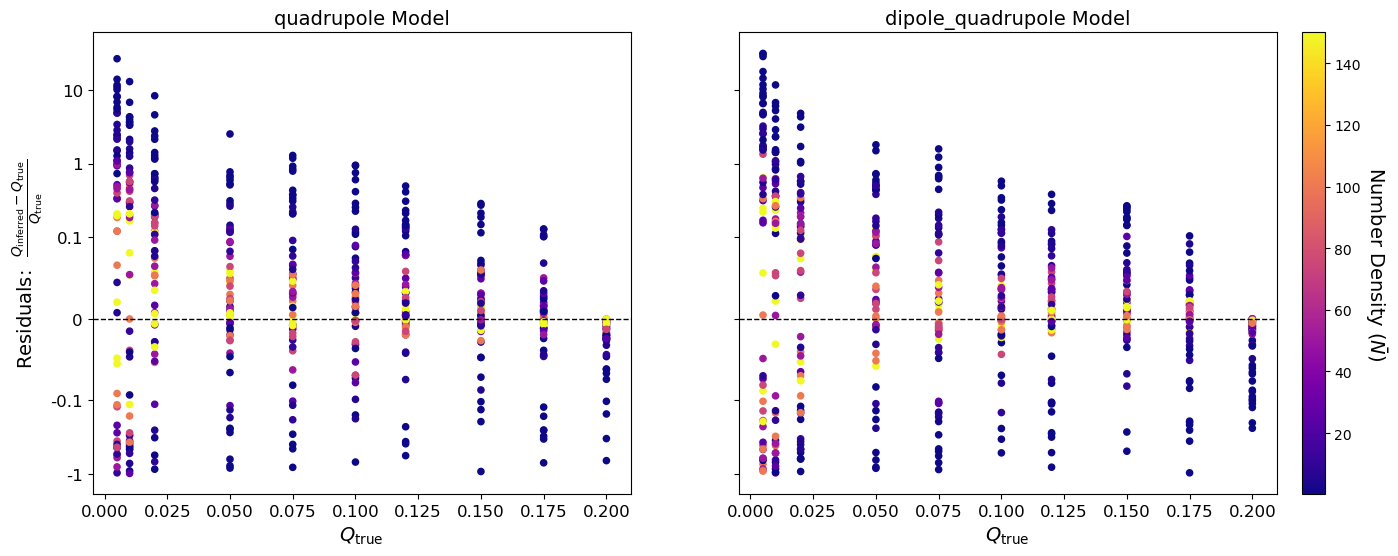

In [133]:
dataframes = [quadrupole_df, dipole_quadrupole_df]

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

for ax, data in zip(axes, dataframes):
    sc = ax.scatter(
        data['Q_true'],
        (data['Q'] - data['Q_true']) / data['Q_true'],
        c=data['Nbar_true'],
        cmap='plasma',
        # norm=LogNorm(),
        s=20
    )
    
    ax.set_title(f"{data['model'].iloc[0]} Model", fontsize=14)
    ax.set_xlabel(r'$Q_{\mathrm{true}}$', fontsize=14)
    ax.axhline(0, color='k', linestyle='--', linewidth=1)
    ax.set_yscale('symlog', linthresh=0.1)
    ax.set_yticks([-1, -0.1, 0, 0.1, 1, 10])
    ax.set_yticklabels([-1, -0.1, 0, 0.1, 1, 10], fontsize=12)
    ax.tick_params(axis='x', labelsize=12)

# Only label the y-axis on the first subplot (shared y-axis)
axes[0].set_ylabel(r'Residuals:  $\frac{Q_{\mathrm{inferred}} - Q_{\mathrm{true}}}{Q_{\mathrm{true}}}$', fontsize=14)
axes[0].tick_params(axis='y', labelsize=12)

# Add a single colorbar for both plots
cbar = fig.colorbar(sc, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.025, pad=0.02)
cbar.set_label(r'Number Density ($\bar{N}$)', rotation=270, labelpad=20, fontsize=14)

# plt.tight_layout()
plt.show()


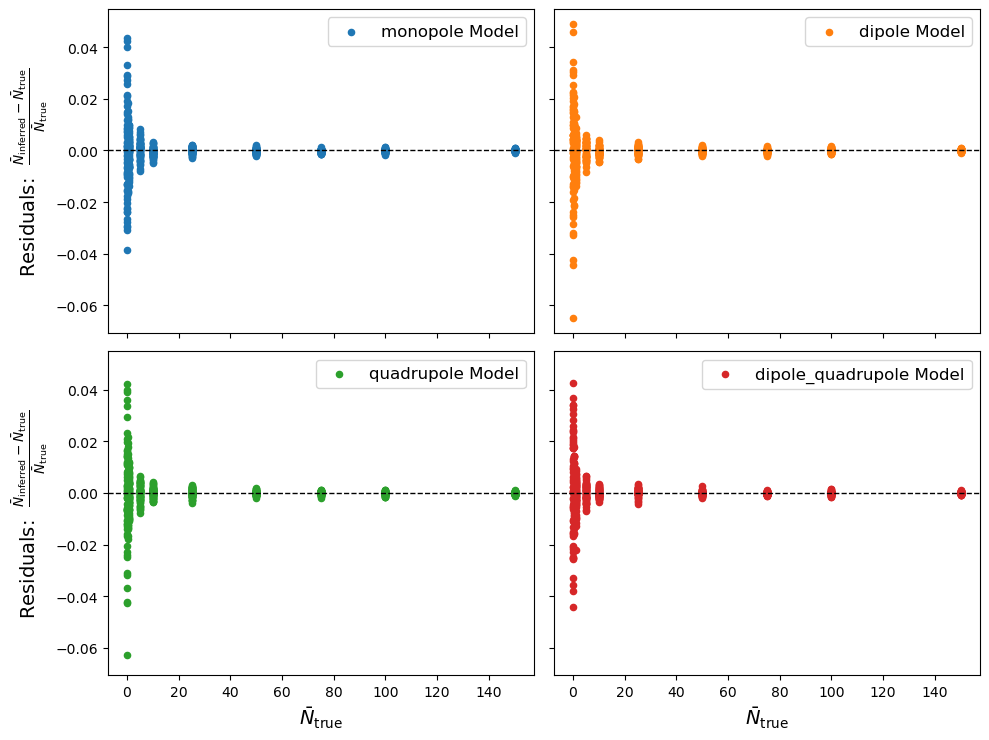

In [138]:
dataframes = [monopole_df, dipole_df, quadrupole_df, dipole_quadrupole_df]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)
axes = axes.flatten()

for i, (ax, data, color) in enumerate(zip(axes, dataframes, colors)):
    scatter = ax.scatter(
        data['Nbar_true'],
        (data['Nbar'] - data['Nbar_true']) / data['Nbar_true'],
        color=color,
        s=20,
        label=f"{data['model'].iloc[0]} Model"
    )
    ax.axhline(0, color='k', linestyle='--', linewidth=1)
    ax.tick_params(axis='both', labelsize=10)

    # Remove y-labels for right column (indices 1 and 3)
    if i % 2 == 1:
        ax.set_ylabel('')
        ax.tick_params(axis='y', labelleft=False)
    else:
        ax.set_ylabel(r'Residuals:  $\frac{\bar{N}_{\mathrm{inferred}} - \bar{N}_{\mathrm{true}}}{\bar{N}_{\mathrm{true}}}$', fontsize=14)

    # Remove x-labels for top row (indices 0 and 1)
    if i < 2:
        ax.set_xlabel('')
        ax.tick_params(axis='x', labelbottom=False)
    else:
        ax.set_xlabel(r'$\bar{N}_{\mathrm{true}}$', fontsize=14)

    # Add legend with marker only (no frame)
    ax.legend(frameon=True, loc='upper right', fontsize=12)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# Matrix style plots of inferred amplitudes

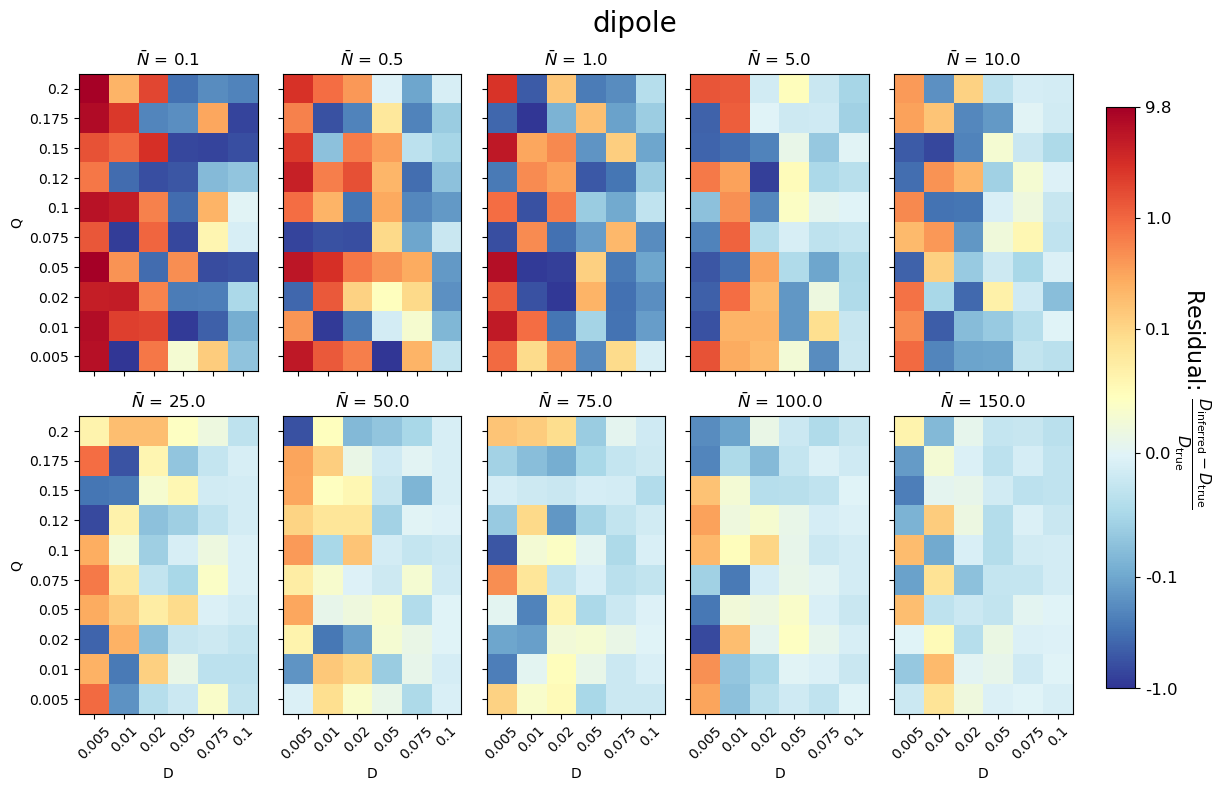

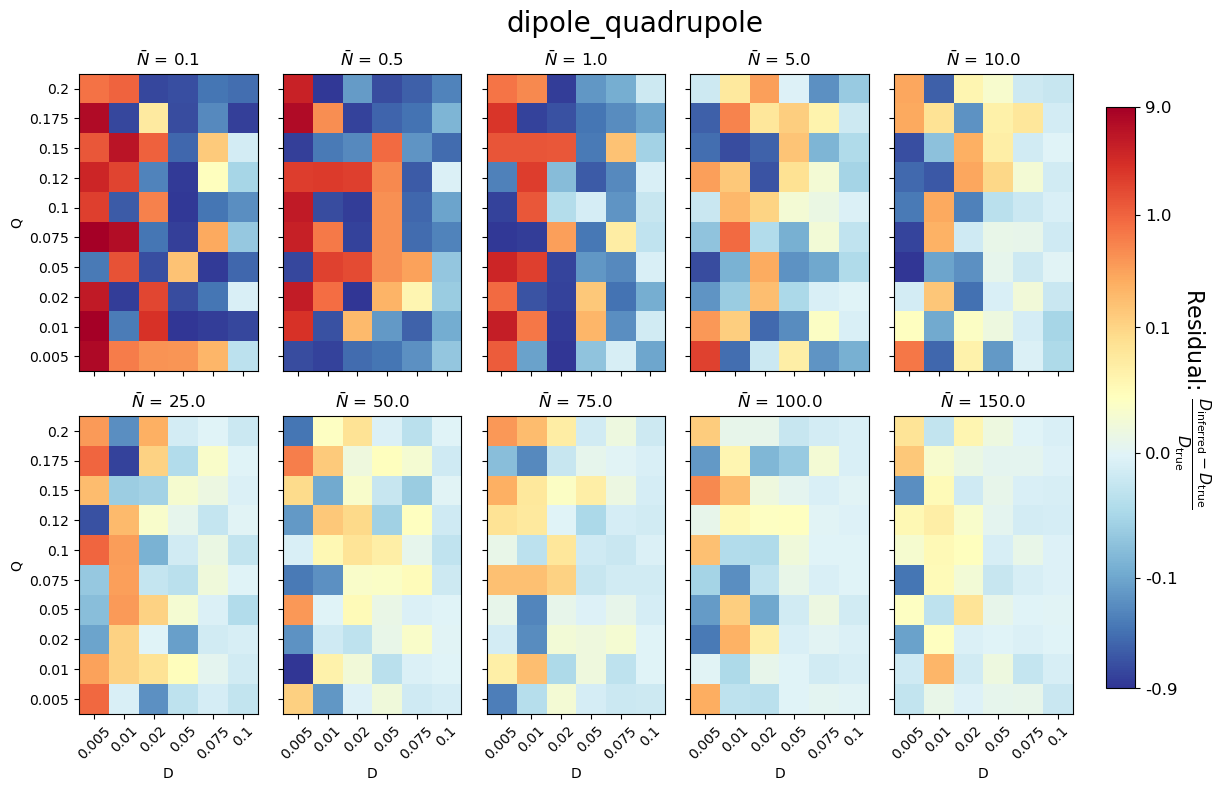

In [204]:
dataframes = [dipole_df, dipole_quadrupole_df]
for data in dataframes:  
    # Convert Series to numpy arrays
    Nbar_inferred = data['Nbar'].values
    D_inferred = data['D'].values
    Q_inferred = data['Q'].values
    Nbar_true = data['Nbar_true'].values
    D_true = data['D_true'].values
    Q_true = data['Q_true'].values

    # Define the fixed D and Q grids
    D_list = [0.005, 0.01, 0.02, 0.05, 0.075, 0.1]
    Q_list = [0.005, 0.01, 0.02, 0.05, 0.075, 0.1, 0.12, 0.15, 0.175, 0.2]

    D_list = sorted(set(D_true))
    Q_list = sorted(set(Q_true))

    # Create mapping from actual values to indices (even bin spacing)
    D_indices = {d: i for i, d in enumerate(D_list)}
    Q_indices = {q: i for i, q in enumerate(Q_list)}

    # def signed_log(x, eps=1e-1):
    #     return np.sign(x) * np.log10(1 + np.abs(x)/eps)

    # # Normalize color scale
    # residuals = (D_inferred - D_true) / D_true
    # signed_res = signed_log(residuals)
    # residual_max = np.max(np.abs(signed_res))
    # residual_min = np.min(signed_res)
    # norm = mcolors.TwoSlopeNorm(vmin=residual_min, vcenter=0, vmax=residual_max)

    residuals = (D_inferred - D_true) / D_true
    linthresh = 0.1  
    residual_max = np.max(np.abs(residuals))
    residual_min = np.min(residuals)
    norm = mcolors.SymLogNorm(linthresh=linthresh, vmin=residual_min, vmax=residual_max)
    
    # Unique Nbar values
    unique_nbar = sorted(set(Nbar_true))
    n_panels = len(unique_nbar)

    # Layout
    ncols = min(5, n_panels)
    nrows = int(np.ceil(n_panels / ncols))

    # Create subplots
    fig, axs = plt.subplots(nrows, ncols, figsize=(2.5 * ncols, 4 * nrows), sharex=True, sharey=True)
    axs = axs.flatten()


    fig.suptitle(data['model'].iloc[0], fontsize=20)

    for i, n in enumerate(unique_nbar):
        ax = axs[i]

        # Filter for current Nbar
        mask = (Nbar_true == n)
        D_n = D_true[mask]
        Q_n = Q_true[mask]
        Dinf_n = D_inferred[mask]

        # Initialize heatmap
        heatmap = np.full((len(Q_list), len(D_list)), np.nan)
        for d_val, q_val, d_inf in zip(D_n, Q_n, Dinf_n):
            if d_val in D_indices and q_val in Q_indices:
                signed_res = (d_inf - d_val) / d_val
                heatmap[Q_indices[q_val], D_indices[d_val]] = signed_res
                
        # Show image
        im = ax.imshow(
            heatmap,
            origin='lower',
            aspect='equal',
            cmap='RdYlBu_r',
            norm=norm,
            extent=[0, len(D_list), 0, len(Q_list)]
        )

        ax.set_title(r'$\bar{N}$ = ' + str(n), fontsize=12)

        # Ticks at bin centers
        ax.set_xticks(np.arange(len(D_list)) + 0.5)
        ax.set_xticklabels(D_list, rotation=45)

        # Always show y tick labels
        ax.set_yticks(np.arange(len(Q_list)) + 0.5)
        ax.set_yticklabels(Q_list)

        # Add axis labels only to left and bottom
        if i % ncols == 0:
            ax.set_ylabel('Q')

        if i >= n_panels - ncols:
            ax.set_xlabel('D')
        else:
            ax.set_xticklabels([])

    # Remove unused axes
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    # Shared colorbar
    tick_vals = [residual_min, -0.1, 0, 0.1, 1, residual_max]
    cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.03, pad=0.04,
                        ticks=tick_vals)
    tick_labels = [f'{v:.1f}' for v in tick_vals]
    cbar.ax.set_yticklabels(tick_labels)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(r'Residual: $\frac{D_{\mathrm{inferred}} - D_{\mathrm{true}}}{D_{\mathrm{true}}}$',
                rotation=270, labelpad=25, fontsize=16)
    plt.subplots_adjust(left=0.05, right=0.85, top=0.9, bottom=0.1, wspace=0.1, hspace=0.15)
    plt.show()

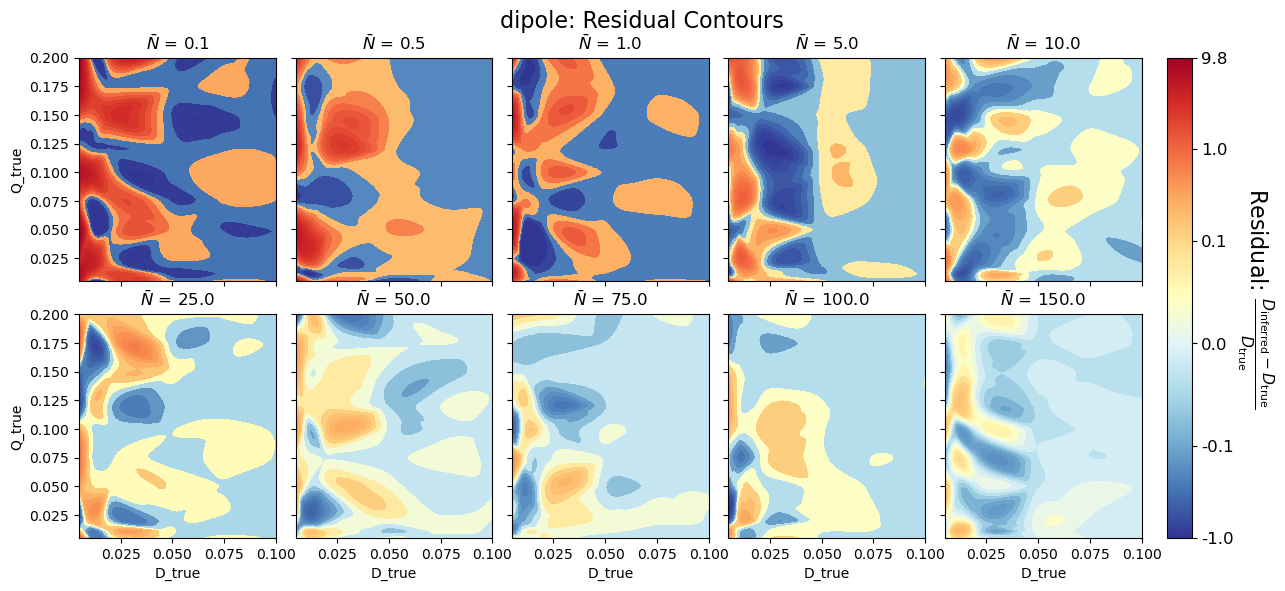

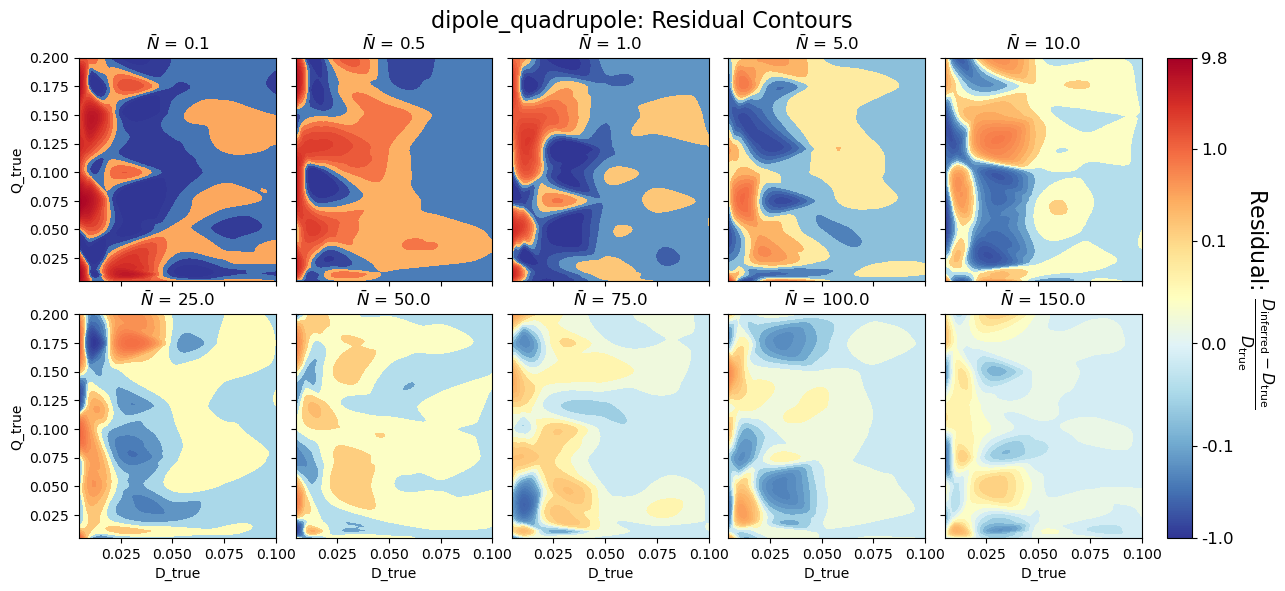

In [ ]:
from scipy.interpolate import griddata

dataframes = [dipole_df, dipole_quadrupole_df]

all_residuals_global = []
for data in dataframes:
    residuals = (data['D'] - data['D_true']) / data['D_true']
    all_residuals_global.extend(residuals)

linthresh = 0.1
residual_max = np.nanmax(np.abs(all_residuals_global))
residual_min = np.min(all_residuals_global)
norm = mcolors.SymLogNorm(linthresh=linthresh, vmin=residual_min, vmax=residual_max)
cmap = 'RdYlBu_r'  # Use a diverging colormap

for data in dataframes:
    model_name = data['model'].iloc[0]
    unique_nbar = sorted(set(data['Nbar_true']))

    ncols = min(5, len(unique_nbar))
    nrows = int(np.ceil(len(unique_nbar) / ncols))
    fig, axs = plt.subplots(nrows, ncols, figsize=(2.5 * ncols, 3 * nrows), sharex=True, sharey=True)
    axs = axs.flatten()

    for i, n in enumerate(unique_nbar):
        ax = axs[i]
        mask = data['Nbar_true'] == n
        D_vals = data['D_true'][mask].to_numpy()
        Q_vals = data['Q_true'][mask].to_numpy()
        D_inf = data['D'][mask].to_numpy()
        res = (D_inf - D_vals) / D_vals

        # Interpolation for smooth contours
        D_fine = np.linspace(min(D_vals), max(D_vals), 100)
        Q_fine = np.linspace(min(Q_vals), max(Q_vals), 100)
        D_grid_fine, Q_grid_fine = np.meshgrid(D_fine, Q_fine)

        points = np.column_stack((D_vals, Q_vals))
        Z_fine = griddata(points, res, (D_grid_fine, Q_grid_fine), method='cubic')

        ax.contourf(D_grid_fine, Q_grid_fine, Z_fine, levels=20, cmap=cmap, norm=norm)
        ax.set_title(r'$\bar{N}$ = ' + str(n), fontsize=12)

        # Only show y-labels on leftmost column
        if i % ncols == 0:
            ax.set_ylabel('Q_true')
        else:
            ax.set_ylabel('')
            ax.tick_params(labelleft=False)

        # Only show x-labels on bottom row
        if i >= ncols * (nrows - 1):
            ax.set_xlabel('D_true')
        else:
            ax.set_xlabel('')
            ax.tick_params(labelbottom=False)

    for j in range(len(unique_nbar), len(axs)):
        fig.delaxes(axs[j])

    fig.suptitle(f'{model_name}: Residual Contours', fontsize=16)


    # Set common colorbar
    tick_vals = [residual_min, -0.1, 0, 0.1, 1, residual_max]
    tick_labels = [f'{v:.1f}' for v in tick_vals]
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
    cbar = fig.colorbar(sm, cax=cbar_ax, ticks=tick_vals)
    cbar.ax.set_yticklabels(tick_labels)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(
        r'Residual: $\frac{D_{\mathrm{inferred}} - D_{\mathrm{true}}}{D_{\mathrm{true}}}$',
        rotation=270, labelpad=30, fontsize=16
    )
    
    plt.subplots_adjust(left=0.05, right=0.9, top=0.9, bottom=0.1, wspace=0.1, hspace=0.15)
    
    plt.show()

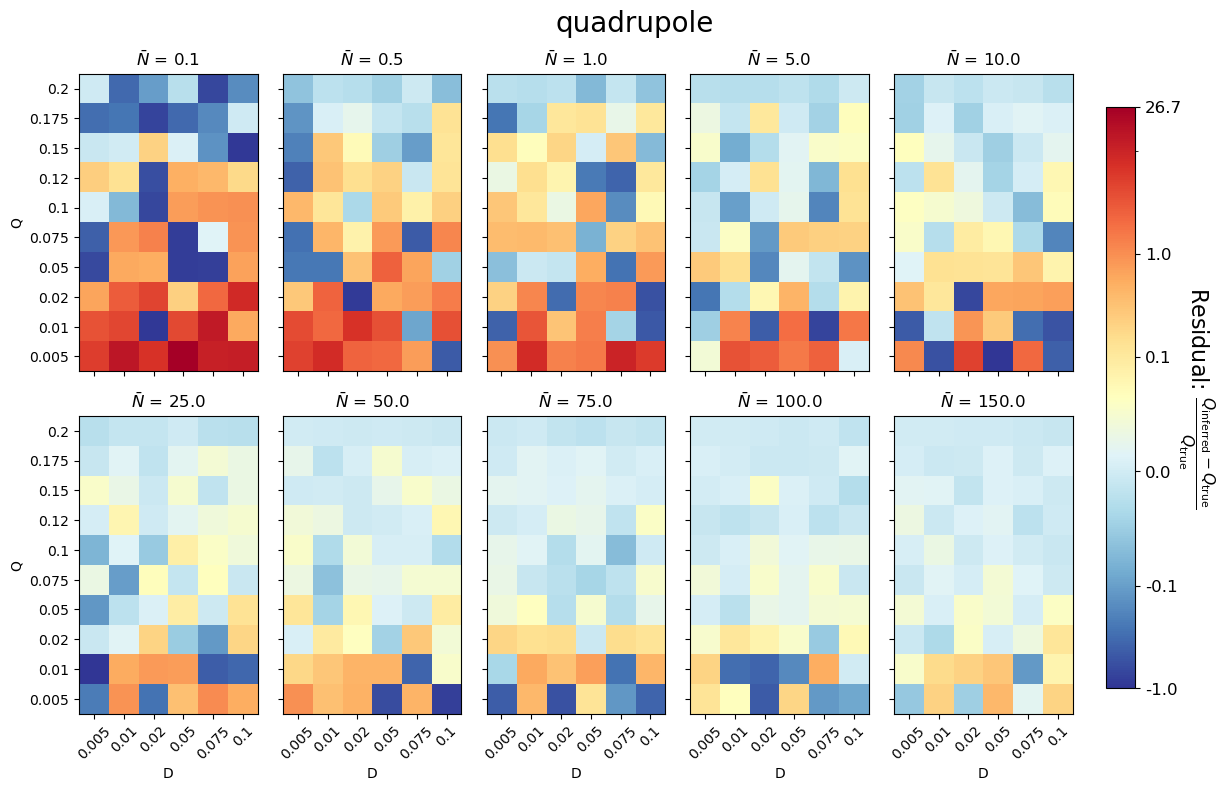

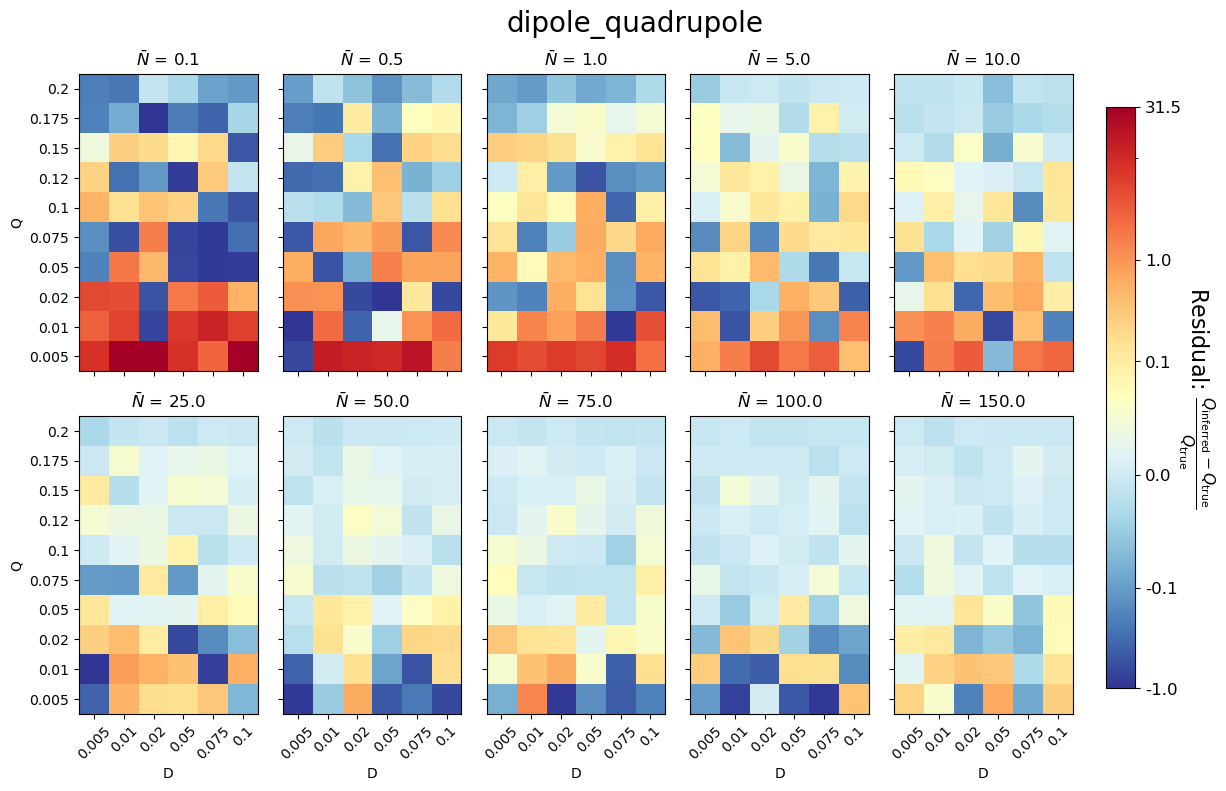

In [207]:
dataframes = [quadrupole_df, dipole_quadrupole_df]
for data in dataframes:  
    # Convert Series to numpy arrays
    Nbar_inferred = data['Nbar'].values
    D_inferred = data['D'].values
    Q_inferred = data['Q'].values
    Nbar_true = data['Nbar_true'].values
    D_true = data['D_true'].values
    Q_true = data['Q_true'].values

    # Define the fixed D and Q grids
    D_list = [0.005, 0.01, 0.02, 0.05, 0.075, 0.1]
    Q_list = [0.005, 0.01, 0.02, 0.05, 0.075, 0.1, 0.12, 0.15, 0.175, 0.2]

    D_list = sorted(set(D_true))
    Q_list = sorted(set(Q_true))

    # Create mapping from actual values to indices (even bin spacing)
    D_indices = {d: i for i, d in enumerate(D_list)}
    Q_indices = {q: i for i, q in enumerate(Q_list)}

    # def signed_log(x, eps=1e-1):
    #     return np.sign(x) * np.log10(1 + np.abs(x)/eps)

    # # Normalize color scale
    # residuals = (D_inferred - D_true) / D_true
    # signed_res = signed_log(residuals)
    # residual_max = np.max(np.abs(signed_res))
    # residual_min = np.min(signed_res)
    # norm = mcolors.TwoSlopeNorm(vmin=residual_min, vcenter=0, vmax=residual_max)

    residuals = (Q_inferred - Q_true) / Q_true
    linthresh = 0.1  
    residual_max = np.max(np.abs(residuals))
    residual_min = np.min(residuals)
    norm = mcolors.SymLogNorm(linthresh=linthresh, vmin=residual_min, vmax=residual_max)
    
    # Unique Nbar values
    unique_nbar = sorted(set(Nbar_true))
    n_panels = len(unique_nbar)

    # Layout
    ncols = min(5, n_panels)
    nrows = int(np.ceil(n_panels / ncols))

    # Create subplots
    fig, axs = plt.subplots(nrows, ncols, figsize=(2.5 * ncols, 4 * nrows), sharex=True, sharey=True)
    axs = axs.flatten()


    fig.suptitle(data['model'].iloc[0], fontsize=20)

    for i, n in enumerate(unique_nbar):
        ax = axs[i]

        # Filter for current Nbar
        mask = (Nbar_true == n)
        D_n = D_true[mask]
        Q_n = Q_true[mask]
        Dinf_n = D_inferred[mask]
        Qinf_n = Q_inferred[mask]

        # Initialize heatmap
        heatmap = np.full((len(Q_list), len(D_list)), np.nan)
        for d_val, q_val, q_inf in zip(D_n, Q_n, Qinf_n):
            if d_val in D_indices and q_val in Q_indices:
                signed_res = (q_inf - q_val) / q_val
                heatmap[Q_indices[q_val], D_indices[d_val]] = signed_res
                
        # Show image
        im = ax.imshow(
            heatmap,
            origin='lower',
            aspect='equal',
            cmap='RdYlBu_r',
            norm=norm,
            extent=[0, len(D_list), 0, len(Q_list)]
        )

        ax.set_title(r'$\bar{N}$ = ' + str(n), fontsize=12)

        # Ticks at bin centers
        ax.set_xticks(np.arange(len(D_list)) + 0.5)
        ax.set_xticklabels(D_list, rotation=45)

        # Always show y tick labels
        ax.set_yticks(np.arange(len(Q_list)) + 0.5)
        ax.set_yticklabels(Q_list)

        # Add axis labels only to left and bottom
        if i % ncols == 0:
            ax.set_ylabel('Q')

        if i >= n_panels - ncols:
            ax.set_xlabel('D')
        else:
            ax.set_xticklabels([])

    # Remove unused axes
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    # Shared colorbar
    tick_vals = [residual_min, -0.1, 0, 0.1, 1, residual_max]
    cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.03, pad=0.04,
                        ticks=tick_vals)
    tick_labels = [f'{v:.1f}' for v in tick_vals]
    cbar.ax.set_yticklabels(tick_labels)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(r'Residual: $\frac{Q_{\mathrm{inferred}} - Q_{\mathrm{true}}}{Q_{\mathrm{true}}}$',
                rotation=270, labelpad=25, fontsize=16)
    plt.subplots_adjust(left=0.05, right=0.85, top=0.9, bottom=0.1, wspace=0.1, hspace=0.15)
    plt.show()

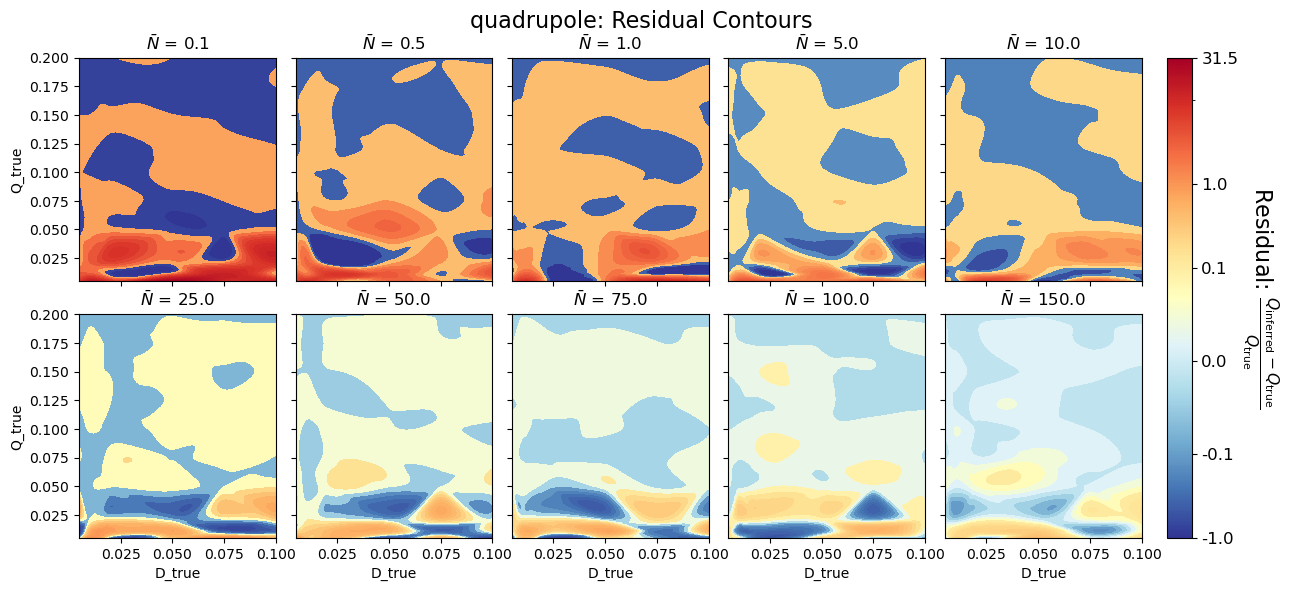

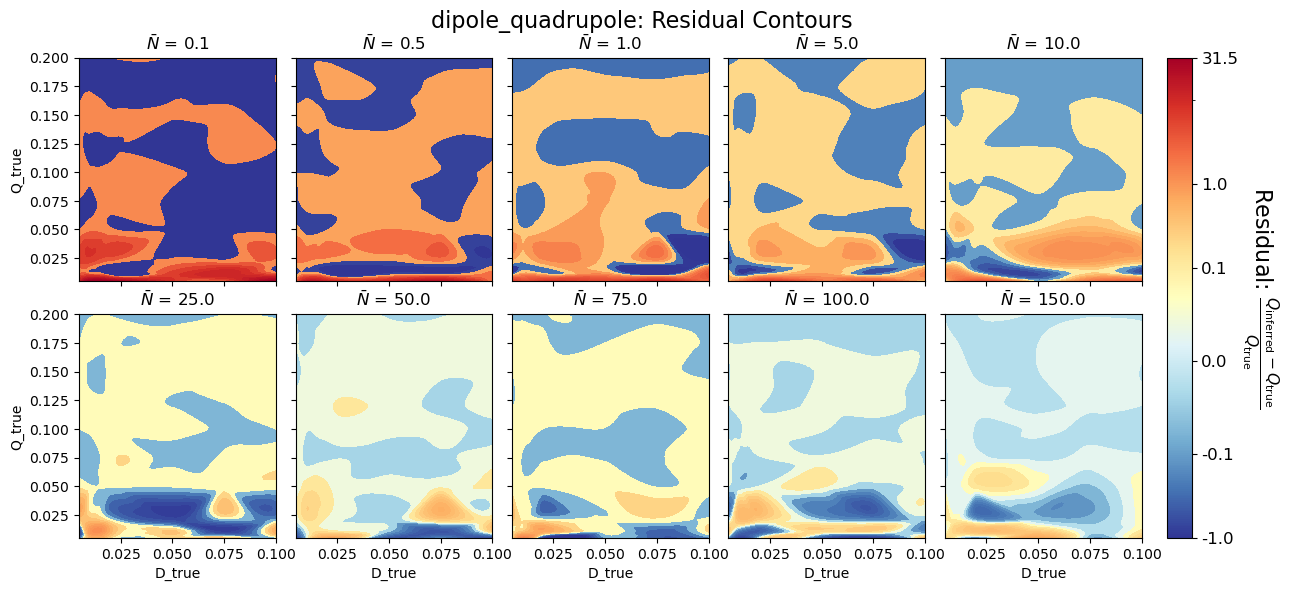

In [208]:
dataframes = [quadrupole_df, dipole_quadrupole_df]

# Step 1: Compute global residuals to determine color normalization
all_residuals_global = []
for data in dataframes:
    residuals = (data['Q'] - data['Q_true']) / data['Q_true']
    all_residuals_global.extend(residuals)

# Step 2: Define SymLogNorm
linthresh = 0.1
residual_max = np.nanmax(np.abs(all_residuals_global))
residual_min = np.min(all_residuals_global)
norm = mcolors.SymLogNorm(linthresh=linthresh, vmin=residual_min, vmax=residual_max)
cmap = 'RdYlBu_r'  # Use a diverging colormap

# Step 3: Plot each dataframe using shared norm and colorbar
for data in dataframes:
    model_name = data['model'].iloc[0]
    unique_nbar = sorted(set(data['Nbar_true']))

    ncols = min(5, len(unique_nbar))
    nrows = int(np.ceil(len(unique_nbar) / ncols))
    fig, axs = plt.subplots(nrows, ncols, figsize=(2.5 * ncols, 3 * nrows), sharex=True, sharey=True)
    axs = axs.flatten()

    for i, n in enumerate(unique_nbar):
        ax = axs[i]
        mask = data['Nbar_true'] == n
        D_vals = data['D_true'][mask].to_numpy()
        Q_vals = data['Q_true'][mask].to_numpy()
        D_inf = data['D'][mask].to_numpy()
        Q_inf = data['Q'][mask].to_numpy()
        res = (Q_inf - Q_vals) / Q_vals

        # Interpolation for smooth contours
        D_fine = np.linspace(min(D_vals), max(D_vals), 100)
        Q_fine = np.linspace(min(Q_vals), max(Q_vals), 100)
        D_grid_fine, Q_grid_fine = np.meshgrid(D_fine, Q_fine)

        points = np.column_stack((D_vals, Q_vals))
        Z_fine = griddata(points, res, (D_grid_fine, Q_grid_fine), method='cubic')

        ax.contourf(D_grid_fine, Q_grid_fine, Z_fine, levels=20, cmap=cmap, norm=norm)
        ax.set_title(r'$\bar{N}$ = ' + str(n), fontsize=12)

        # Only show y-labels on leftmost column
        if i % ncols == 0:
            ax.set_ylabel('Q_true')
        else:
            ax.set_ylabel('')
            ax.tick_params(labelleft=False)

        # Only show x-labels on bottom row
        if i >= ncols * (nrows - 1):
            ax.set_xlabel('D_true')
        else:
            ax.set_xlabel('')
            ax.tick_params(labelbottom=False)

    for j in range(len(unique_nbar), len(axs)):
        fig.delaxes(axs[j])

    fig.suptitle(f'{model_name}: Residual Contours', fontsize=16)


    # Set common colorbar
    tick_vals = [residual_min, -0.1, 0, 0.1, 1, residual_max]
    tick_labels = [f'{v:.1f}' for v in tick_vals]
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
    cbar = fig.colorbar(sm, cax=cbar_ax, ticks=tick_vals)
    cbar.ax.set_yticklabels(tick_labels)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(
        r'Residual: $\frac{Q_{\mathrm{inferred}} - Q_{\mathrm{true}}}{Q_{\mathrm{true}}}$',
        rotation=270, labelpad=30, fontsize=16
    )
    
    plt.subplots_adjust(left=0.05, right=0.9, top=0.9, bottom=0.1, wspace=0.1, hspace=0.15)
    
    plt.show()